# init

In [1]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [2]:
import base.dfBasics as dfBasics
import base.common as common
import base.encoder as encoder
import base.pfAdapt as pfAdapt
#import base.charts as charts
#import base.anomaly as anomaly

import pandas as pd    
from pyspark.sql import functions

In [3]:
sparkSession = dfBasics.getSparkSession()

### load data

In [4]:
#df = pd.read_parquet('/home/jovyan/work/output/sla_enc_all_4.parquet')

In [5]:
#senders = pd.unique(df['CSENDERENDPOINTID'])

## functions

In [6]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def make_2digits(blist):
    for n, b in enumerate(blist):
        if int(b) < 10:
             blist[n] = '0' + str(b)
    return blist

def get_ymd_string(a,b,c) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] 
    elif isinstance(a,pd.core.series.Series):
        return a.astype(str) + "-" + make_2digits(b.astype(str)) + "-" + make_2digits(c.astype(str))
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdhm(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    e = mdcountsall.index.get_level_values(4).astype(str)
    return a,b,c,d,e

def get_ymdh_string(a,b,c,d) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] + "-" + make_2digits([d])[0]
    elif isinstance(a,pd.core.series.Series):
        return a.astype(str) + "-" + make_2digits(b.astype(str)) + "-" + make_2digits(c.astype(str)) + "-" + make_2digits(d.astype(str))
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) + "-" + pd.Index(make_2digits(d.tolist()))

def get_ymdhm_string(a,b,c,d,e) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] + "-" + make_2digits([d])[0] + "-" + make_2digits([e])[0]
    elif isinstance(a,pd.core.series.Series):
        return a.astype(str) + "-" + make_2digits(b.astype(str)) + "-" + make_2digits(c.astype(str)) + "-" + make_2digits(d.astype(str)) + "-" + make_2digits(e.astype(str))
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) + "-" + pd.Index(make_2digits(d.tolist())) + "-" + pd.Index(make_2digits(e.tolist()))


def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month=-1,year=2020,outcome='outcome') :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2[outcome] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2


def createData_ymd(pfall,month,year=2020) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData_ymdh(pfall,month,year=2020) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['hour'] = d.astype(int)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData_ymdhm(pfall,month,year=2020) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour','minute'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour','minute'])['year'].count()    
    a,b,c,d,e = get_ymdhm(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['hour'] = d.astype(int)
    data2['minute'] = e.astype(int)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2


def createData_column_ymdh(pfall,month=-1,year=2020, column=None) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)]
    else :
        mdcountsall = pfall 
    #a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(pfall['year'], pfall['month'], pfall['day'],pfall['hour'])
    df2 = mdcountsall[['year', 'month', 'day','hour',column]].copy()
    data2 = pd.concat([data2, df2], axis=1)
    data2.columns = list(data2.columns[:-1]) + ['outcome']
    
    return data2


def createData_column_ymd(pfall,month=-1,year=2020, column=None) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)]
    else :
        mdcountsall = pfall 
    #a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(pfall['year'], pfall['month'], pfall['day'])
    df2 = mdcountsall[['year', 'month', 'day',column]].copy()
    data2 = pd.concat([data2, df2], axis=1)
    data2.columns = list(data2.columns[:-1]) + ['outcome']
    
    return data2


def label(graph,skip,rot) :
    #print(len(graph.get_xticklabels()))
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)



Setup Complete


In [7]:
def label_skip(a):
    print(a)
    b=a
    if a > 12:
        b = (a - 12) / 12
    return int(b)    

### visualization

In [8]:
def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    label(ax,label_skip(len(ax.get_xticklabels())),75)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

In [9]:
#pfall
#pfall5 = createData_column_ymdh(pfall,column='CMESSAGETAT2')
#get_ymdh_string(pfall5['year'], pfall5['month'], pfall5['day'],pfall5['hour'])
#pfall5['year']
#pfall5['year'].astype(str) + '_' + make_2digits(pfall5['month'].astype(str))
#make_2digits([c])[0] 

#pfall5.columns = pfall5.columns[:-1] + 'outcome'
#pfall5.columns = list(pfall5.columns[:-1]) + ['outcome']
#pfall5

In [10]:
#year=2022
#month=7
#mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()

In [11]:
#pfall

In [12]:
#checka(pfall[(pfall[year]== 2022) & (pfall[month]== 7)])
#pfall[(pfall[year]== '2022') & (pfall[month]== '7')]
#pfall[(pfall[year] == 2022)] 
#pfall
#pfall5 = createData_column_ymdh(pfall,column='CMESSAGETAT2')
#pfall6 = checka(pfall5)
#pd.unique(pfall5['year'])

### check

In [13]:
from calendar import monthrange

def get_month(pda, year=2020, month=1):
    return pda[(pda['month'] == month) & (pda['year'] == year)]

def is_complete(pda, year=2020, month=1):
    mm = pda[(pda['month'] == month) & (pda['year'] == year)]
    if len(mm) > 0:
        return monthrange(year, month)[1] == len(mm)
    return None
    
def check_complete(pda, year=2020):
    for m in range(1, 13):
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        if len(mm) > 0:
            print(m,monthrange(year, m)[1] == len(mm))

            
def add_line_to_dataframe(df=None,year=None,month=None,day=None,hour=None,minute=None,value=0): 
    
    if hour is not None:
        if minute is not None:
            _date = get_ymdhm_string(str(year),str(month),str(day),str(hour),str(minute)) 
            df.loc[len(df)]=[_date,year,month,day,hour,minute,value]  
        else:    
            _date = get_ymdh_string(str(year),str(month),str(day),str(hour)) 
            df.loc[len(df)]=[_date,year,month,day,hour,value]   
    else:    
        _date = get_ymd_string(str(year),str(month),str(day))
        df.loc[len(df)]=[_date,year,month,day,value]     
    
def check_and_fill_hours_of_day(df=None,year=2022,month=7,day=None):
    _df=df[(df['year']==year) & (df['month']==month) & (df['day']==day)] 
    #print(_df)
    
    minutes = False
    if 'minute' in df.columns:
        minutes = True
    
    for hour in range(0, 24):
        if len(_df[_df['hour']==hour]) == 0:
            if minutes == True:
                for minute in range(0, 59):
                    #_date = get_ymdhm_string(str(year),str(month),str(day),str(hour),str(minute))  
                    add_line_to_dataframe(df=df,year=year,month=month,day=day,hour=hour,minute=minute) 
            else:
                #_date = get_ymdh_string(str(year),str(month),str(day),str(hour))  
                add_line_to_dataframe(df=df,year=year,month=month,day=day,hour=hour) 
        else:
            if minutes == True:
                _df2 = _df[_df['hour']==hour]
                for minute in range(0, 59):
                    if len(_df2[_df2['minute']==minute]) == 0:
                        add_line_to_dataframe(df=df,year=year,month=month,day=day,hour=hour,minute=minute)
            else:
                pass
    #print (df)        
    return df     
    
    
#pda :  date,year,month,day.outcome 
def fill(pda,year,month,min_day=1,max_day=-1,hours=False): 
    if max_day == -1:
        days = monthrange(year, month)[1]
    else:
        days = max_day
        
    #print(min_day,days,max_day,hours)     
    minutes = False
    if 'minute' in pda.columns:
        minutes = True
        
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(min_day, days + 1):
        if len(df[df['day']==day]) == 0:
            #print(day)
            if hours == True:
                for hour in range (0,24):
                    if minutes == True:
                        for minute in range(0, 59): 
                            add_line_to_dataframe(df=pda,year=year,month=month,day=day,hour=hour,minute=minute) 
                    else:
                        add_line_to_dataframe(df=pda,year=year,month=month,day=day,hour=hour) 
            else:    
                add_line_to_dataframe(df=pda,year=year,month=month,day=day)
        else:
            if hours == True:
                #print(year,month,day)
                check_and_fill_hours_of_day(df=pda,year=year,month=month,day=day)
       
    
def check(pda):
    _start_year = min(pd.unique(pda['year']))
    _end_year = max(pd.unique(pda['year']))  
    _start_month = min(pd.unique(pda[pda['year']== _start_year]['month']))
    _end_month = max(pd.unique(pda[pda['year']== _end_year]['month']))
    _end = 13
    
    if 'hour' in pda.columns:
        hours = True
    else:
        hours = False
        
    for year in range(_start_year,_end_year+1):   
        for month in range(_start_month,_end):        
            #print(year,month, _end_month, _end_year)
            
            if((month == _start_month) & (year == _start_year)):
                min_day = (min(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
            else:
                min_day = 1
                
            if((month == _end_month) & (year == _end_year)):
                max_day = (max(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
                #print(month,year,max_day)
                fill(pda,year,month,min_day=min_day, max_day=max_day,hours=hours)
            else:    
                fill(pda,year,month,min_day=min_day,hours=hours)
            if (year == _end_year) &  (month == _end_month):
                #print('DONE')
                break    
        _start_month=1
            
        if year == (_end_year-1):
            _end = _end_month + 1     
            
        if (year == _end_year) &  (month == _end_month):
            #print('DONE')
            break       
            

### checka

In [14]:
# 2019-10-29-00
# 2022-10-06-23

def mean_column(column):
    return int(round(column.mean(),0))

def check_and_fill_hours_of_daya(df=None,year=2022,month=7,day=None, outcome='outcome'):
    _df=df[(df['year']==year) & (df['month']==month) & (df['day']==day)] 
    
    df=pd.DataFrame(columns=['date', 'year', 'month', 'day', 'hour', outcome])
    for hour in range(0, 24):
        _hours = _df[_df['hour']==hour]
        if len(_df[_df['hour']==hour]) == 0:
            _date = get_ymdh_string(str(year),str(month),str(day),str(hour))  
            add_line_to_dataframe(df=df,year=year,month=month,day=day,hour=hour) 
            pass
        else:
            add_line_to_dataframe(df=df,year=year,month=month,day=day,hour=hour,value=mean_column(_hours[outcome]))
    #print (df)      
    return df 

#pda :  date,year,month,day.outcome 
def filla(pda,year,month,min_day=1,max_day=-1,hours=False, outcome='outcome'): 
    if max_day == -1:
        days = monthrange(year, month)[1]
    else:
        days = max_day
        
    #df = pda[(pda['month'] == month) & (pda['year'] == year)]
    if hours == True:
        df=pd.DataFrame(columns=['date', 'year', 'month', 'day', 'hour', outcome])
    else:
        df=pd.DataFrame(columns=['date', 'year', 'month', 'day', outcome])
        
    for day in range(min_day, days + 1):
        if hours == True:
            df_b = check_and_fill_hours_of_daya(df=pda,year=year,month=month,day=day,outcome=outcome)
            df = pd.concat([df, df_b], ignore_index=True)   
        else:
            _df=pda[(pda['year']==year) & (pda['month']==month) & (pda['day']==day)]
            if len(_df) > 0 :
                #print(len(_df),mean_column(_df['outcome']), list(_df['outcome']))
                value=mean_column(_df[outcome])
            else:
                value=0
            add_line_to_dataframe(df=df,year=year,month=month,day=day,value=value) 
    return df   
            
    
def checka(pda, outcome='outcome'):
    _start_year = min(pd.unique(pda['year']))
    _end_year = max(pd.unique(pda['year']))  
    _start_month = min(pd.unique(pda[pda['year']== _start_year]['month']))
    _end_month = max(pd.unique(pda[pda['year']== _end_year]['month']))
    _end = 13
    
    if 'hour' in pda.columns:
        hours = True
        df=pd.DataFrame(columns=['date', 'year', 'month', 'day', 'hour', outcome])
    else:
        hours = False
        df=pd.DataFrame(columns=['date', 'year', 'month', 'day', outcome])
    
    
    for year in range(_start_year,_end_year+1):   
        for month in range(_start_month,_end):        
            #print(year,month, _end_month, _end_year)
            
            if((month == _start_month) & (year == _start_year)):
                min_day = (min(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
            else:
                min_day = 1
                
            if((month == _end_month) & (year == _end_year)):
                max_day = (max(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
                #print(month,year,max_day)
                df_b = filla(pda,year,month,min_day=min_day, max_day=max_day,hours=hours,outcome=outcome)
                df = pd.concat([df, df_b], ignore_index=True)
            else:    
                df_b =  filla(pda,year,month,min_day=min_day,hours=hours,outcome=outcome)
                df = pd.concat([df, df_b], ignore_index=True)
            if (year == _end_year) &  (month == _end_month):
                #print('DONE')
                break    
        _start_month=1
            
        if year == (_end_year-1):
            _end = _end_month + 1     
            
        if (year == _end_year) &  (month == _end_month):
            #print('DONE')
            break       
    return df        
           

In [15]:
def get_date_list(pda, hours=False):
    _start_year = min(pd.unique(pda['year']))
    _end_year = max(pd.unique(pda['year']))  
    _start_month = min(pd.unique(pda[pda['year']== _start_year]['month']))
    _end_month = max(pd.unique(pda[pda['year']== _end_year]['month']))
    _end = 13
    
    _date_list = []
    
    for year in range(_start_year,_end_year+1):   
        for month in range(_start_month,_end):        
            #print(year,month, _end_month, _end_year)
            
            if((month == _start_month) & (year == _start_year)):
                min_day = (min(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
            else:
                min_day = 1
            
            if((month == _end_month) & (year == _end_year)):
                days = (max(list(pda[(pda['month'] == month) & (pda['year'] == year)]['day'])))
            else:
                days = monthrange(year, month)[1]
            
            for day in range(min_day, days + 1):
                if hours == True:
                    for hour in range(0, 24):
                        _date = get_ymdh_string(str(year),str(month),str(day),str(hour)) 
                        _date_list.append(_date) 
                else:
                    _date = get_ymd_string(str(year),str(month),str(day))
                    _date_list.append(_date)    
            
            if (year == _end_year) &  (month == _end_month):
                #print('DONE')
                break    
        _start_month=1
            
        if year == (_end_year-1):
            _end = _end_month + 1     
            
        if (year == _end_year) &  (month == _end_month):
            #print('DONE')
            break       
    return _date_list        
           

In [16]:
def check_and_fill_hours_of_month(dataframe=None,year=2022,month=7):
    
    days=pd.unique(dataframe['days'])
    _start_day = min(days)
    _end_day   = max(days)  

    for day in range(_start_day,_end_day+1):
        _df=dataframe[dataframe['days']==day] 
        for hour in range(0, 24):
            if len(_df[_df['hours']==hour]) == 0:
                _date = get_ymdh_string(str(year),str(month),str(day),str(hour))  
                #print([_date,0,hour,day])
                dataframe.loc[len(dataframe)]=[_date,0,hour,day]
    return dataframe       

In [17]:
def check_complete(dataframe=None,year=2020):
    for m in range(1, 13):
        #print(m)
        mm = dataframe[(dataframe['month'] == m) & (dataframe['year'] == year)]
        print(m,monthrange(year, m)[1] == len(mm))

def fill1(pda,year,month):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(1, days + 1):
        if len(df[df['day']==day]) == 0:
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
    

In [18]:
def unique(pfall):
    return pd.unique(pfall['CRECEIVERENDPOINTID']), pd.unique(pfall['CSTATUS']), pd.unique(pfall['CSERVICE']), pd.unique(pfall['CSENDERPROTOCOL']), pd.unique(pfall['CRECEIVERPROTOCOL'])

#un=unique(pfall)
#unique(pfall[pfall['CRECEIVERENDPOINTID']==725])

#pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==un[0][1]]
#pda = createData_ymd(pfall0,0)

#del pda['index'] 

In [19]:
class Time(object):         
    def __init__(self,year=None,month=None,day=None):
        self.year  = self._int_value(year)
        self.month = self._int_value(month)
        self.day   = self._int_value(day)
    
    def _int_value(self,value):
        if value == '' or value == None:
            return None
        return int(value)
        

class TimeRange(object):    
    def __init__(self,dataframe=None,year_from=None,month_from=None,day_from=None,year_to=None,month_to=None,day_to=None):
        if dataframe is None:
            self.start = Time(year=year_from,month=month_from,day=day_from).__dict__
            self.end   = Time(year_to,month_to,day_to).__dict__
        else:
            #print(dataframe)
            year_from = min(pd.unique(dataframe['year']))
            year_to = max(pd.unique(dataframe['year']))  
            month_from = min(pd.unique(dataframe[dataframe['year']== year_from]['month']))
            month_to = max(pd.unique(dataframe[dataframe['year']== year_to]['month']))
            day_from = min(pd.unique(dataframe[(dataframe['year']== year_from) & (dataframe['month'] == month_from)]['day']))
            day_to = max(pd.unique(dataframe[(dataframe['year']== year_to) & (dataframe['month'] == month_to)]['day']))
            self.start = Time(year_from,month_from,day_from).__dict__
            self.end   = Time(year_to,month_to,day_to).__dict__
            
#TimeRange(dataframe=pfall).__dict__  

def set_date_widget_value(element, value):
    if value != None:
        element.value = str(value)
    else:
        element.value = ''

def init_date_widget(_res):
    _range = TimeRange(dataframe=_res)
    set_date_widget_value(year_from, _range.start['year'])
    set_date_widget_value(month_from, _range.start['month'])
    set_date_widget_value(day_from, _range.start['day'])
    
    set_date_widget_value(year_to, _range.end['year'])
    set_date_widget_value(month_to, _range.end['month'])
    set_date_widget_value(day_to, _range.end['day'])

In [20]:
def createHeatmapPfall(pfall=None,sender='all',month=1,year=2020,values='outcome',index='hours',columns='days'):
    #print(month,year)
    global data2
    global piv
    data2 = createData(pfall,month,year=year)
    piv = pd.pivot_table(data2, values=values,index=[index], columns=[columns], fill_value=0)
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
    titlestring ="number messages " + str(year) + "-" + str(month) + "  " + sender
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    createHeatmap(piv, titlestring)

In [21]:
def on_value_submit_month(change):
    #adapt_all()    
    sender=0
   
    with out:
        clear_output()
        month=int(month_from.value)
        year=int(year_from.value)
        createHeatmapPfall(pfall0,"endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID),month=month, year=year)
        #print(int(month_from.value), year_from.value)
        #createHeatmapPfall(pfall=pfall,sender='all',month=1,year=2020)
        
        md2 = createData_ymd(pfall0,month,year=year)
        ax=createBarplot(md2,fx=24,fy=12,fontscale=3.0,title="number messages " + "endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID))
        label(ax,1000,90)

### other

In [22]:
def replace_index_by_date_column(df,column='date'):
    df.set_index(df[column], inplace=True)
    #del df['index']
    #del df['date']
    return df

## create data

In [23]:
def create_data(pfall):
    global pda_hour
    global pda_CMESSAGETAT2_hour
    
    pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
    del pfall1['index']
    del pfall1['CGLOBALMESSAGEID']

    pfall0 = pfall

    ####
    pda_hour = createData_ymdh(pfall0,0)
    check(pda_hour)
    pda_hour = pda_hour.sort_values(['date']).reset_index()
    _index = replace_index_by_date_column(pda_hour)

    ####
    #_column = 'CINBOUNDSIZE'
    _column='CMESSAGETAT2'
    pfall5 = createData_column_ymdh(pfall,column=_column)
    pda_CMESSAGETAT2_hour = checka(pfall5 ).sort_values(['date'])
    #pda_CINBOUNDSIZE_hour = checka(pfall5 ).sort_values(['date'])
    _index = replace_index_by_date_column(pda_CMESSAGETAT2_hour)

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [24]:
def get_trained_period(anomalyEnc):
    return anomalyEnc.train.index[0], anomalyEnc.train.index[len(anomalyEnc.train.index)-1]

def get_test_period(anomalyEnc):
    return anomalyEnc.test.index[0], anomalyEnc.test.index[len(anomalyEnc.test) -1]

def get_period(pfall,percent = 1.0):
    max_index = int(len(pfall1) * percent)
    return pfall.iloc[pfall.index[0]]['date'], pfall.iloc[pfall.index[max_index -1]]['date']

def get_percent(pfall1,year=None,month=None,day=None,hour=None):
    _pfall = pfall1[(pfall1['year'] == year) & (pfall1['month'] == month)]
    if day != None:
        _pfall = _pfall[(_pfall['day'] == day)]
    if hour != None:
        _pfall = _pfall[(_pfall['hour'] == hour)]
    
    index = _pfall.index[len(_pfall.index)-1]    
    #print(index)
    index = pfall1.index.get_loc(index)
    
    return (index + 1) / len(pfall1)
    #return _pfall.index
    
def get_index_period(pfall):
    max_index = int(len(pfall) * percent) -1
    return pfall.index[0], pfall.index[max_index]
    


### train models

In [25]:
import AnomalyDetectionLSTMAutoencoder

def train_model(dataframe=None, time_steps=30, year=2022,month=6,day=None,hour=None):
    anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = time_steps)
    #anomalyEnc.initAndTrain_divide(dataframe, get_percent(dataframe,year=year,month=month,day=day,hour=hour))
    
    dataframe['datetime']  = pd.to_datetime(dataframe[["year", "month", "day", "hour"]])
    
    anomalyEnc.df1 = anomalyEnc.createDataframe(dataframe)
    anomalyEnc.df1['datetime'] = dataframe['datetime']
    
    perc_train = get_percent(dataframe,year=year,month=month,day=day,hour=hour)
    train, test = anomalyEnc.getTrainAndTest(anomalyEnc.df1,perc_train)
    anomalyEnc.initAndTrain(train=train, test=test)
    
    return anomalyEnc

Setup Complete


In [26]:
def get_anomalies(anomalyEnc,threshold):
    anomalyEnc.evaluateAnomalies(threshold)
    anomalyEnc.anomalies['datetime'] = anomalyEnc.test['datetime']
    return anomalyEnc.anomalies

In [27]:
def numpy_to_dataframe(b):
    _df = pd.DataFrame()
    _df['outcome'] = b.reshape([1, len(b)])[0]
    return _df

In [28]:
def train_models():
    global anomalyEnc_hour
    global anomalyEnc_CMESSAGETAT2_hour
    anomalyEnc_hour = train_model(dataframe=pda_hour,time_steps=24, year=2020,month=12)
    _anomalies = get_anomalies(anomalyEnc_hour,0.9).index

    anomalyEnc_CMESSAGETAT2_hour = train_model(dataframe=pda_CMESSAGETAT2_hour,time_steps=24, year=2020,month=12)
    _anomalies = get_anomalies(anomalyEnc_CMESSAGETAT2_hour,0.9).index

#### SAVE scaler, test 

In [29]:
#https://machinelearningmastery.com/how-to-save-and-load-models-and-data-preparation-in-scikit-learn-for-later-use/
#anomalyEnc2.test.head()
#anomalyEnc2.scaler

from pickle import dump
# save the model
#dump(model, open('model.pkl', 'wb'))
# save the scaler

def save_models():
    from pathlib import Path
    _path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_hour/'
    _enc = anomalyEnc_hour
    Path(_path).mkdir(parents=True, exist_ok=True)
    dump(_enc.scaler, open(_path + 'scaler.pkl', 'wb'))
    _enc.test.to_parquet(_path + 'test.parquet')

    _path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_CMESSAGETAT2_hour/'
    _enc = anomalyEnc_CMESSAGETAT2_hour
    Path(_path).mkdir(parents=True, exist_ok=True)
    dump(_enc.scaler, open(_path + 'scaler.pkl', 'wb'))
    _enc.test.to_parquet(_path + 'test.parquet')

### functions

In [30]:
def scatterplot(index, values,label):
    return sns.scatterplot(
      x=index,
      y=values,
      color=sns.color_palette()[3],
      #s=152,
      s=50,  
      label=label
      #linewidth=5  
    )
    
def plot_test(test,scaler,anomalies,titlestring,xlabel):

    fig = plt.figure(figsize=(18,9))
    
    plt.plot(
      test[anomalyEnc.TIME_STEPS:].index, 
      #scaler.inverse_transform(test[TIME_STEPS:].close), 
      scaler.inverse_transform(test[anomalyEnc.TIME_STEPS:]),   
      label='msg count'
    );

    #ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies['close']), 'anomaly')  
    #ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies), 'anomaly')
    _a=anomalyEnc.anomalies['close']
    _a = pd.DataFrame(_a)
    _a = anomalyEnc.scaler.inverse_transform(_a)
    _a = _a[:, 0]
    #print(_a,type(_a),_a[0],len(_a),len(_a[:, 0]))
    ax = scatterplot(anomalyEnc.anomalies.index, _a, 'anomaly') 
    
    ax.set_xlabel(xlabel)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.xticks(rotation=25)
    plt.legend();

    label(ax,5,80)
    plt.title(titlestring)
    plt.show(fig)


### Problems / Erwartungsmonitoring

- am 12.07.2022 wurde ein BIS Release installiert dass zur Verzögerung vieler Nachrichten geführt hat.
Die letzten Nachrichten wurden am Folgetag um ca. 15:00 Uhr CET verarbeitet.
Es sollten also deutliche Anomalien zwischen 12.07.2022 (10:00 Uhr) bis 13.07.2022 (15:00 Uhr) zu sehen sein.


- 13.09.2022 19:00 Uhr / 20:00 Uhr UTC: Massive Last, Anflutung des Systems, vor allem im zweiten Intervall.
Durchlaufzeiten waren deutlich erhöht. 


### plot graphs

In [31]:
def plot_graph(_df,contains=None, y='outcome'):
    _df2 = _df[_df.index.str.contains(contains)]

    fig = plt.figure(figsize=(18,9))
    
    hours= False
    
    plt.plot(_df2.index, _df2[y], label=y)
    if len(_df2.index[0].split('-')) == 4:
        hours = True
        ticks=_df2.index[_df2.index.str.contains('-00')]
        ticks2 = list(ticks)
        ticks2.append('2022-07-12-10')
        ticks2.append('2022-07-13-15')
        ticks2.sort()
        ticks = ticks2
    elif len(_df2.index[0].split('-')) == 3:
        ticks=list(_df2.index[_df2.index.str.contains('-01')])  
        for day in range(2,10):
            ticks.remove('2022-01-0' + str(day))
        for day in range(10,32):
            ticks.remove('2022-01-' + str(day)) 
        b=(len(ticks)-1)    
        ticks = ticks[:6] + ['2022-07-12'] + ticks[6:b]     
    else:
        ticks=_df2.index
    #ticks=[_df2.index[0]]
    
    #12.07.2022 (10:00 Uhr) bis 13.07.2022 (15:00 Uhr)
    if hours == False:
        plt.axvline(x='2022-07-12', color="red")
        plt.axvline(x='2022-09-13', color="red")
    else:    
         plt.axvline(x='2022-07-12-10', color="red")
         plt.axvline(x='2022-07-13-15', color="red")
         #plt.axvline(x='2022-09-13-19', color="red")
         #plt.axvline(x='2022-09-13-20', color="red")
       
    #print(ticks)
    
    plt.legend();
    plt.xticks(rotation=80,ticks=ticks)
    plt.show(fig)
    return ticks    



def plot_graph2(test=None, expect=None, column_y='outcome',contains=None, date_from=None, date_to=None):
        
    _test =test
    
    if contains is not None:
        _test = _test[_test.index.str.contains(contains)]
        #anomalies = anomalies[anomalies.index.str.contains(contains)]
    elif date_from is not None and date_to is not None:
        _from_index = _test.index.get_loc(date_from)
        _to_index   = _test.index.get_loc(date_to)
        #_df2 = _df2[_df2.index[_from_index:_to_index + 1]]
        _test = _test.iloc[_from_index:_to_index + 1]
    else:
        pass    
            
    fig = plt.figure(figsize=(18,9))
    plt.plot(_test.index, _test[column_y])       
    
    ticks = (_test.index[0], _test.index[len(_test.index) - 1])
    plt.xticks(rotation=80,ticks=ticks)
    
    if expect is not None:
        #print(_test.index.get_loc(expect[0]),_test.index.get_loc(expect[1]))
        e1=_test.index.get_loc(expect[0])
        e2=_test.index.get_loc(expect[1])
        x = np.arange(e1,e2)
        #x = np.arange(expect[0],expect[1])
        _max = np.max(_test[column_y])
        y1 = [0]*len(x)
        y2 = [_max]*len(x)
        plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
    plt.show()

### filtered plot

In [32]:
def inverse_transform_anomalies(scaler=None,anomalies=None, column_y='close'):
    _a = anomalies[column_y]
    _a = pd.DataFrame(_a)
    _a = scaler.inverse_transform(_a)
    _a = _a[:, 0]
    return _a

def filtered_plot(test=None,scaler=None,anomalies=None,TIME_STEPS=None,contains=None, date_from=None, date_to=None,titlestring='',xlabel='',skip=None,rotate=80):
    #_df2 = test[TIME_STEPS:]
    _df2 = test
    
    if contains is not None:
        _df2 = _df2[_df2.index.str.contains(contains)]
        anomalies = anomalies[anomalies.index.str.contains(contains)]
    elif date_from is not None and date_to is not None:
        _from_index = _df2.index.get_loc(date_from)
        _to_index   = _df2.index.get_loc(date_to)
        #_df2 = _df2[_df2.index[_from_index:_to_index + 1]]
        _df2 = _df2.iloc[_from_index:_to_index + 1]
        
        anomalies = anomalies.iloc[_from_index:_to_index + 1]
        
        for date in anomalyEnc6.anomalies.index:
            if date >= '2022-07-01-00':
                _min = anomalyEnc6.anomalies.index.get_loc(date)
                break     
        for _max in range(_min,len(anomalyEnc6.anomalies.index)):
            if anomalyEnc6.anomalies.index[_max] > '2022-07-07-23':
                break
        anomalies = anomalies.iloc[_min:_max]         
    else:
        pass
    
    _a = inverse_transform_anomalies(scaler=scaler,anomalies=anomalies, column_y='close')
    
    fig = plt.figure(figsize=(30,12))

    plt.plot(
      _df2.index,  
      scaler.inverse_transform(_df2),   
      label='msg count'
    );

    
    
    ax = scatterplot(anomalies.index, _a, 'anomaly') 

    if skip is not None:
        label(ax,skip,rotate)
    
    hours= False
    if len(_df2.index[0].split('-')) == 4:
        hours = True
    if hours == False:
        plt.axvline(x='2022-07-12', color="red")
        #plt.axvline(x='2022-07-13', color="red")
        #plt.axvline(x='2022-09-13', color="red")
    else:    
        plt.axvline(x='2022-07-12-10', color="red")
        plt.axvline(x='2022-07-13-15', color="red")
        #plt.axvline(x='2022-09-13-19', color="red")
        #plt.axvline(x='2022-09-13-20', color="red")
        
    plt.title(titlestring)
    #plt.show(fig)     
        
def filtered_plot_enc(anomalyEnc, contains=None,date_from=None, date_to=None,titlestring='',xlabel='',skip=None,rotate=80):     
    return filtered_plot(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,anomalyEnc.TIME_STEPS,contains,date_from, date_to,titlestring,xlabel,skip,rotate)   

In [33]:
def filtered_plot2(test=None,scaler=None,anomalies=None,TIME_STEPS=None,contains=None, date_from=None, date_to=None,titlestring='',xlabel='',skip=None,rotate=80, annotations=True, ylabel='msg count'):
    #_df2 = test[TIME_STEPS:]
    _df2 = test
    
    if contains is not None:
        _df2 = _df2[_df2.index.str.contains(contains)]
        anomalies = anomalies[anomalies.index.str.contains(contains)]
    elif date_from is not None and date_to is not None:
        _from_index = _df2.index.get_loc(date_from)
        _to_index   = _df2.index.get_loc(date_to)
        #_df2 = _df2[_df2.index[_from_index:_to_index + 1]]
        _df2 = _df2.iloc[_from_index:_to_index + 1]
    else:
        pass
    
    _a = anomalies['close']
    _a = pd.DataFrame(_a)
    _a = scaler.inverse_transform(_a)
    _a = _a[:, 0]
    
    fig = plt.figure(figsize=(30,12))

    skip_x = label_skip(len(_df2.index))
    
    plt.plot(
      _df2.index,  
      scaler.inverse_transform(_df2),   
      label=ylabel
    );

    plt.xticks( _df2.index[0::skip_x],rotation=70,fontsize=10)
    plt.yticks(fontsize=10)
    
    skip_x = label_skip(len(anomalies.index))
    
    ax = scatterplot(anomalies.index, _a, 'anomaly') 

    #if skip is not None:
    #    label(ax,skip,rotate)
    
    hours= False
    if len(_df2.index[0].split('-')) == 4:
        hours = True
        
    if annotations == True:    
        if hours == False:
            plt.axvline(x='2022-07-12', color="red")
            #plt.axvline(x='2022-07-13', color="red")
            #plt.axvline(x='2022-09-13', color="red")
        else:    
            plt.axvline(x='2022-07-12-10', color="red")
            plt.axvline(x='2022-07-13-15', color="red")
            #plt.axvline(x='2022-09-13-19', color="red")
            #plt.axvline(x='2022-09-13-20', color="red")
        
    plt.title(titlestring)
    #plt.show(fig)     
        

def filtered_plot_enc2(anomalyEnc, contains=None,date_from=None, date_to=None,titlestring='',xlabel='',skip=None,rotate=80, annotations=True, ylabel='msg count'):     
    return filtered_plot2(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,anomalyEnc.TIME_STEPS,contains,date_from, date_to,titlestring,xlabel,skip,rotate, annotations=annotations, ylabel=ylabel)   

### plot_error

In [364]:
def plt_add_anomaly(_df2):
    hours= False
    if len(_df2.index[0].split('-')) == 4:
        hours = True
    if hours == False:
        plt.axvline(x='2022-07-12', color="red")
        #plt.axvline(x='2022-07-13', color="red")
        #plt.axvline(x='2022-09-13', color="red")
    else:    
        plt.axvline(x='2022-07-12-10', color="red")
        plt.axvline(x='2022-07-13-15', color="red")
        #plt.axvline(x='2022-09-13-19', color="red")
        #plt.axvline(x='2022-09-13-20', color="red")

import datetime as dt

from datetime import time
import datetime as dt

def add_datetime_column(dataframe):
    _date = []
    for i,row in dataframe.iterrows():
        _date.append(dt.datetime.strptime(i, "%Y-%m-%d-%H"))
    dataframe['datetime'] = _date    

def get_closest_datestring(datestring='2022-07-13-15',dates=None):
    date = datetime.datetime.strptime(datestring, "%Y-%m-%d-%H")
    #dates = anomalyEnc2.anomalies['date']
    _dt = min(dates, key=lambda d: abs(d - date))
    _date = make_2digits([_dt.date().month, _dt.date().day, _dt.time().hour])
    return  str(_dt.date().year) + '-' + str(_date[0])  + '-' + str(_date[1]) + '-' + str(_date[2])
        
def filter_dataframe(dataframe,contains=None, date_from=None, date_to=None):        
    if contains is not None:
        dataframe1 = dataframe[dataframe.index.str.contains(contains)]
    elif date_from is not None and date_to is not None:
        _from_index = dataframe.index.get_loc(date_from)
        _to_index   = dataframe.index.get_loc(date_to)
        dataframe1 = dataframe.iloc[_from_index:_to_index + 1]   
    return dataframe1
    
def plot_error(anomalyEnc=None, score=None, anomalies=None, contains=None, date_from=None, date_to=None):
    fig = plt.figure(figsize=(18,9))
    #_test = anomalyEnc.test_score_df.iloc[2050:]
    
    if score is None:
        _test = anomalyEnc.test_score_df
    else:
        _test = score
    
    if anomalies is None:
        _anomalies = anomalyEnc.anomalies
    else:
        _anomalies = anomalies
    
    date_from = get_closest_datestring(datestring=date_from,dates=_test['datetime'])
    date_to = get_closest_datestring(datestring=date_to,dates=_test['datetime'])
    
    _test = filter_dataframe(_test,contains=contains, date_from=date_from, date_to=date_to)
    
    
    
    
    _threshold= pd.unique(_anomalies['threshold'])[0]
    
    plt.axhline(y=_threshold, color="red",linewidth = 3) 
    plt.plot(_test.index, _test['loss'])   
    
    
    #ticks = (_test.index[0], _test.index[len(_test.index) - 1])
    #plt.xticks(rotation=80,ticks=ticks)
    skip_x = label_skip(len(_test.index))
    plt.xticks( _test.index[0::skip_x],rotation=70,fontsize=10)
    plt.yticks(fontsize=10)
    
    plt_add_anomaly(_test)
    
    # monthly lines
    for timestring in _test[_test.index.str.contains('-01-00')].index:
        plt.axvline(x=timestring, color="grey")
    
    plt.show(fig)

In [35]:
def update_threshold_for_error_in_timerange(enc,date_from='2022-07-12-10',date_to='2022-07-13-15'):
    _test = filter_dataframe(enc.test_score_df,date_from='2022-07-12-10',date_to='2022-07-13-15')
    _threshold = _test.iloc[0]['loss']
    _anomalies = get_anomalies(enc,_threshold).index

In [36]:
def update_thresholds():
    update_threshold_for_error_in_timerange(anomalyEnc_hour,date_from='2022-07-12-10',date_to='2022-07-13-15')
    update_threshold_for_error_in_timerange(anomalyEnc_CMESSAGETAT2_hour,date_from='2022-07-12-10',date_to='2022-07-13-15')

#### SAVE anomalies, errors

In [37]:
def save_errors():
    _path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_hour/'
    _enc = anomalyEnc_hour
    _enc.anomalies.to_parquet(_path + 'anomalies.parquet')
    _enc.test_score_df.to_parquet(_path + 'test_score_df.parquet')

    _path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_CMESSAGETAT2_hour/'
    _enc = anomalyEnc_CMESSAGETAT2_hour
    _enc.anomalies.to_parquet(_path + 'anomalies.parquet')
    _enc.test_score_df.to_parquet(_path + 'test_score_df.parquet')

### plot_clusters

In [180]:
clusters

array([array([12, 13, 29]), array([20, 20,  1])], dtype=object)

In [236]:
#plot_monthly_clusters(anomalies=anomalies2[anomalies2.index.str.contains('2022-07')],clusters=clusters,scaler=scaler,test=test, date_from='2022-07-01-00',date_to='2022-07-31-23',expect=('2022-07-12-10','2022-07-13-15'))

#plot_clusters(anomalies=anomalies2[anomalies2.index.str.contains('2022-07')],clusters=clusters,scaler=scaler,test=test, date_from='2022-07-01-00',date_to='2022-07-31-23',expect=('2022-07-12-10','2022-07-13-15'))
#test['datetime']

In [306]:
#plot_monthly_clusters(anomalies=anomalies2[anomalies2.index.str.contains('2022-07')],clusters=clusters,scaler=scaler,test=test, date_from='2022-07-01-00',date_to='2022-07-31-23',expect=('2022-07-12-10','2022-07-13-15'))


In [255]:
#anomalies = anomalies2[anomalies2.index.str.contains('2022-07')]
_anomalies = anomalies2

In [262]:
#max(_anomalies.loc[(_anomalies['datetime'] >= '2022-07-12-00') & (_anomalies['datetime'] <= '2022-07-12-23')]['datetime'])

_timestamps = _anomalies.loc[(_anomalies['datetime'] >= datetime.datetime(2022, 7, 12, 0)) & (_anomalies['datetime'] <= datetime.datetime(2022, 7, 12, 23))]
_timestamps = _anomalies.loc[(_anomalies['datetime'] >= start) & (_anomalies['datetime'] <= end)]

#_timestamps.head()
#datetime.datetime(2022, 7, 12, 0),start

In [376]:
def get_next_datestrings_of_timerange(dataframe=None, start=None, end=None):
    if isinstance(start,pd.Timestamp):
        _timestamps = dataframe.loc[(dataframe['datetime'] >= start) & (dataframe['datetime'] <= end)]['datetime']
    else:    
        _timestamps = dataframe.loc[(dataframe['datetime'] >= datetime.datetime(*start)) & (dataframe['datetime'] <= datetime.datetime(*end))]['datetime']  
    _timestamps = min(_timestamps),max(_timestamps)
    _range = dataframe[(dataframe['datetime'] == _timestamps[0])].index[0],dataframe[(dataframe['datetime'] == _timestamps[1])].index[0] 
    return _range 
    
_range = get_next_datestrings_of_timerange(dataframe=anomalies2,start=(2022, 7, 20,0),end=(2022, 7, 20,23))    
_range

('2022-07-20-02', '2022-07-20-13')

In [377]:
start = all_clusters[(2022,1)][0][0]
end = all_clusters[(2022,1)][0][1]
get_next_datestrings_of_timerange(dataframe=anomalies2, start=start, end=end)

('2022-01-03-14', '2022-01-05-21')

In [375]:
isinstance(start,pd.Timestamp)

True

In [363]:
import calendar

def filter_dataframe_datetime(dataframe,start,end):
    return dataframe.loc[(dataframe['datetime'] >= start) & (dataframe['datetime'] <= end)]

def filter_dataframe_month(dataframe,year=None,month=None):
    start=datetime.datetime(year,month,1,0) 
    end=datetime.datetime(year,month,calendar.monthrange(year, month)[1],23)
    return filter_dataframe_datetime(dataframe,start,end)
    
#filter_dataframe_month(dataframe=anomalies2,year=2022,month=5)    

In [199]:
for cluster in clusters:
        _range = get_next_datestrings_of_timerange(dataframe=anomalies2,start=(2022, 7, cluster[0],0),end=(2022, 7, cluster[1],23))   
        #plot_bounding_box(_range,_test,_scaler,color='yellow') 
        print(_range)
        
clusters        

('2022-07-12-11', '2022-07-13-16')
('2022-07-20-00', '2022-07-20-00')


array([array([12, 13, 29]), array([20, 20,  1])], dtype=object)

#### create clusters

In [357]:
def create_date_cluster_h(anomalies3):
    month_datelist = list(anomalies3['datetime'])
    _start=month_datelist[0]
    _current = _start
    _count = 0
    _results=[]
    for date in month_datelist :
        if (date - _current).seconds//3600 > 1:
                _results.append((_start,_current,_count))
                _start = date
                _count = 0
        _current = date  
        _count = _count + 1
    _results.append((_start,_current,_count))   
    return _results

#anomalies3=filter_dataframe_month(anomalies2,year=2022,month=2)
#create_date_cluster_h(anomalies3)

In [446]:
def create_all_clusters(anomalies2,year=2022):
    all_clusters={}
    year=2022
    for month in range(1,13):
        anomalies3=filter_dataframe_month(anomalies2,year=year,month=month)
        #clusters=create_date_cluster(anomalies3)
        clusters=create_date_cluster_h(anomalies3)
        all_clusters[(year,month)]=clusters
    return all_clusters
#all_clusters    
#sender

In [450]:
#all_clusters

8760


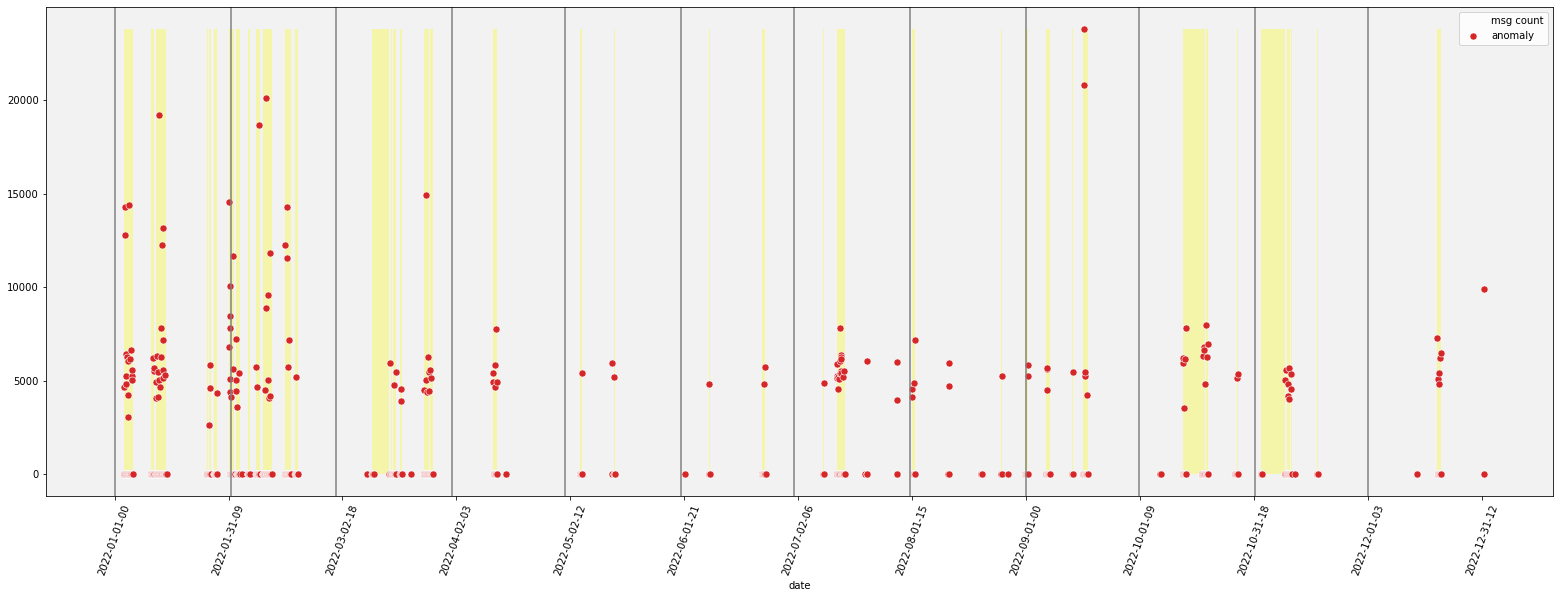

In [378]:
plot_monthly_clusters(anomalies=anomalies2,clusters=all_clusters,scaler=scaler,test=test, date_from='2022-01-01-00',date_to='2022-12-31-23')

##### lines

In [ ]:
plot_monthly_clusters(anomalies=anomalies2,clusters=all_clusters,scaler=scaler,test=test, date_from='2022-01-01-00',date_to='2022-12-31-23')

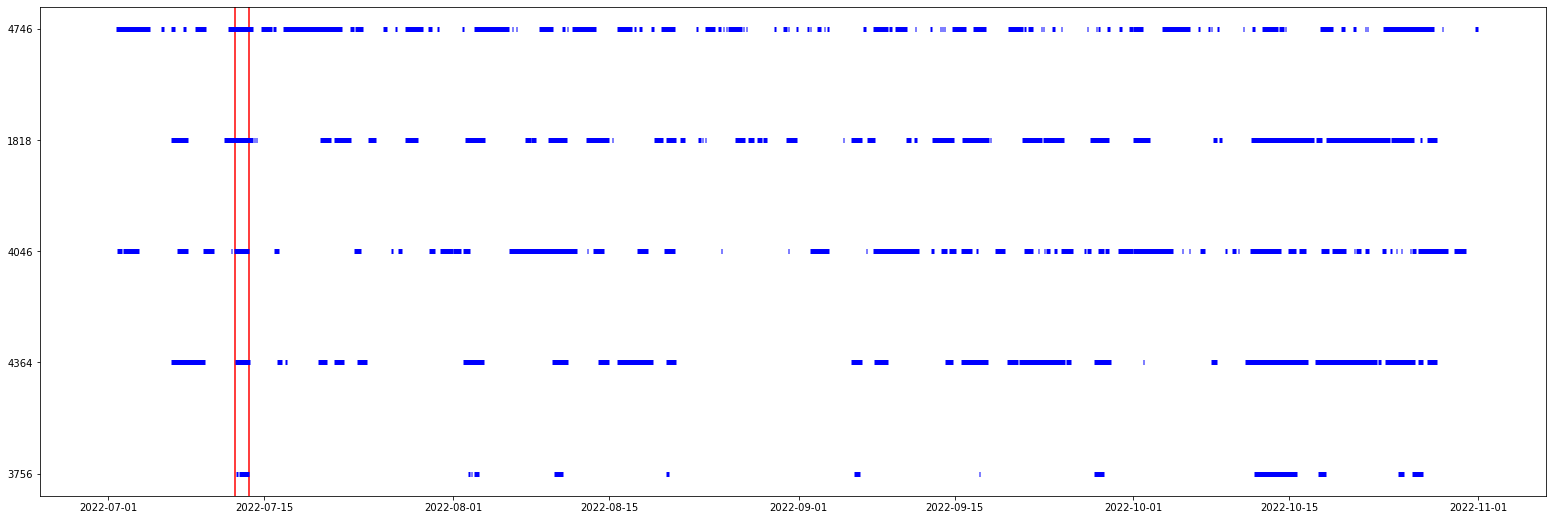

In [487]:
plot_clusters_lines(clusters=all_sender_clusters,date_from=datetime.datetime(2022,7,1,0),date_to=datetime.datetime(2022,10,31,23))

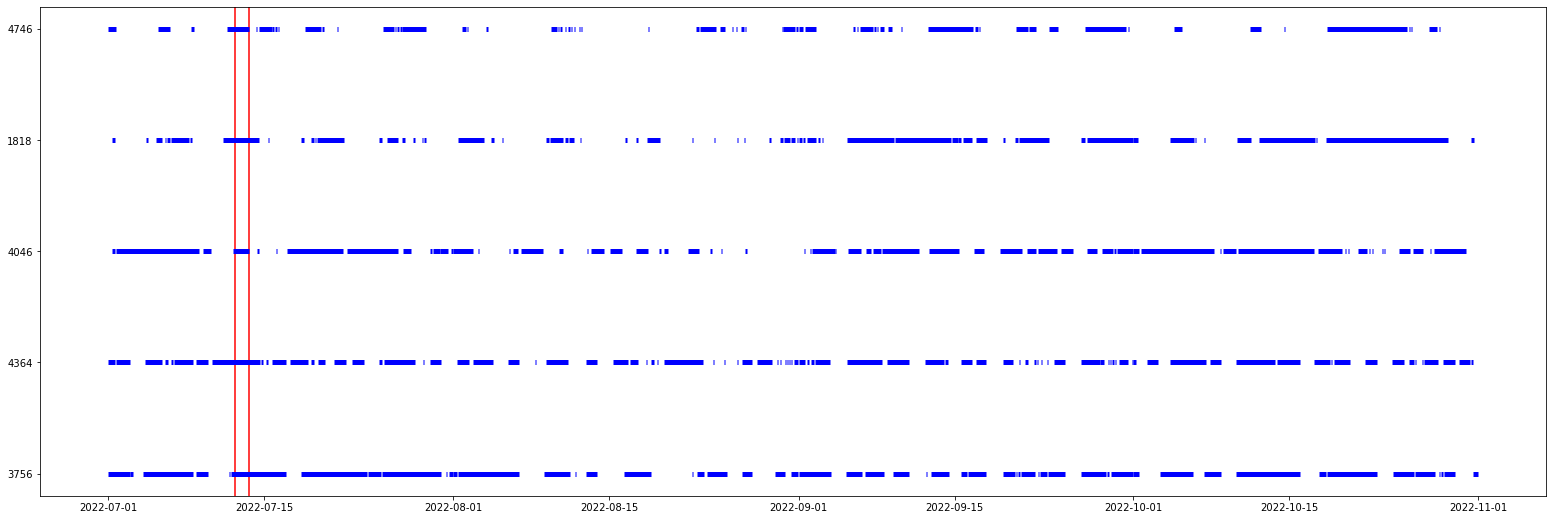

In [630]:
plot_clusters_lines(clusters2=all_sender_clusters_anomalyEnc_hour_statistics3,date_from=datetime.datetime(2022,7,1,0),date_to=datetime.datetime(2022,10,31,23))

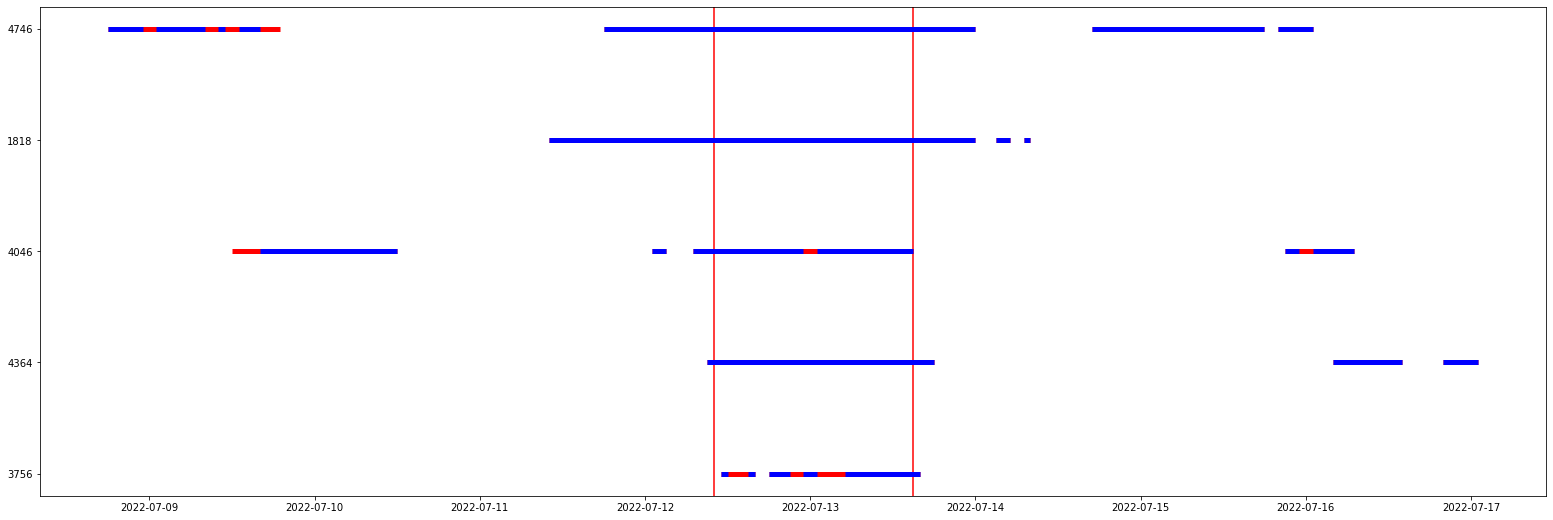

In [593]:
#plot_clusters_lines(clusters1=all_sender_clusters, clusters2=all_sender_clusters_nn,date_from=datetime.datetime(2022,7,1,0),date_to=datetime.datetime(2022,8,31,23))
plot_clusters_lines(clusters1=all_sender_clusters_statistics3, clusters2=all_sender_clusters_nn_statistics3, date_from=datetime.datetime(2022,7,8,0),date_to=datetime.datetime(2022,7,18,23))

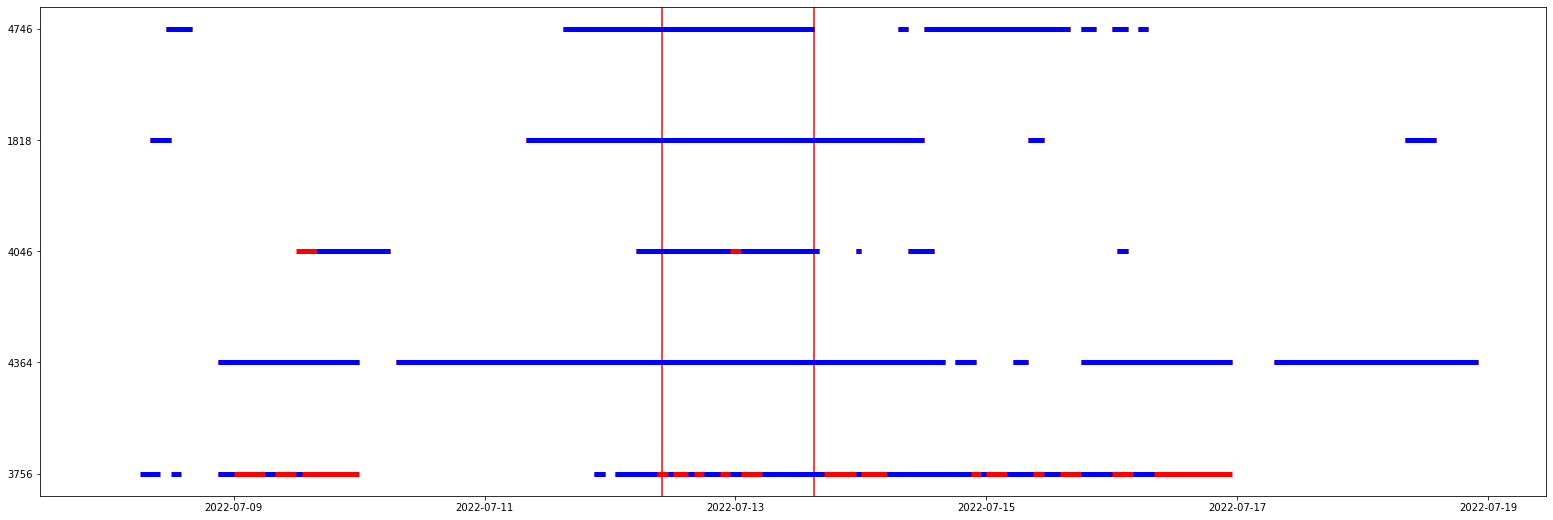

In [623]:
plot_clusters_lines(clusters1=all_sender_clusters_anomalyEnc_hour_statistics3, clusters2=all_sender_clusters_anomalyEnc_hour_nn_statistics3, date_from=datetime.datetime(2022,7,8,0),date_to=datetime.datetime(2022,7,18,23))

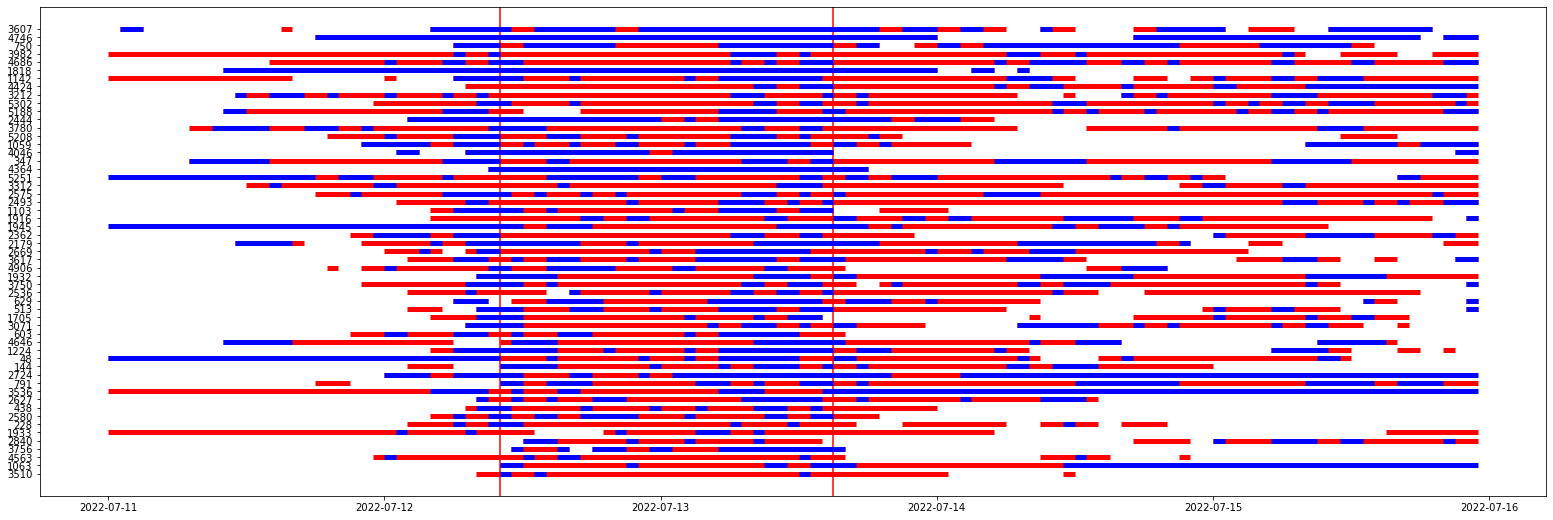

In [646]:
#all_sender_clusters_statistics2 = all_sender_clusters
#all_sender_clusters_statistics3 = all_sender_clusters
#all_sender_clusters_nn_statistics3 = all_sender_clusters_nn
#all_sender_clusters_nn_statistics2 = all_sender_clusters_nn
#plot_clusters_lines(clusters1=all_sender_clusters_statistics2, clusters2=all_sender_clusters_nn_statistics2,date_from=datetime.datetime(2022,7,1,0),date_to=datetime.datetime(2022,7,31,23))
plot_clusters_lines(clusters1=all_sender_clusters_statistics2, clusters2=all_sender_clusters_nn_statistics2, date_from=datetime.datetime(2022,7,11,0),date_to=datetime.datetime(2022,7,15,23))

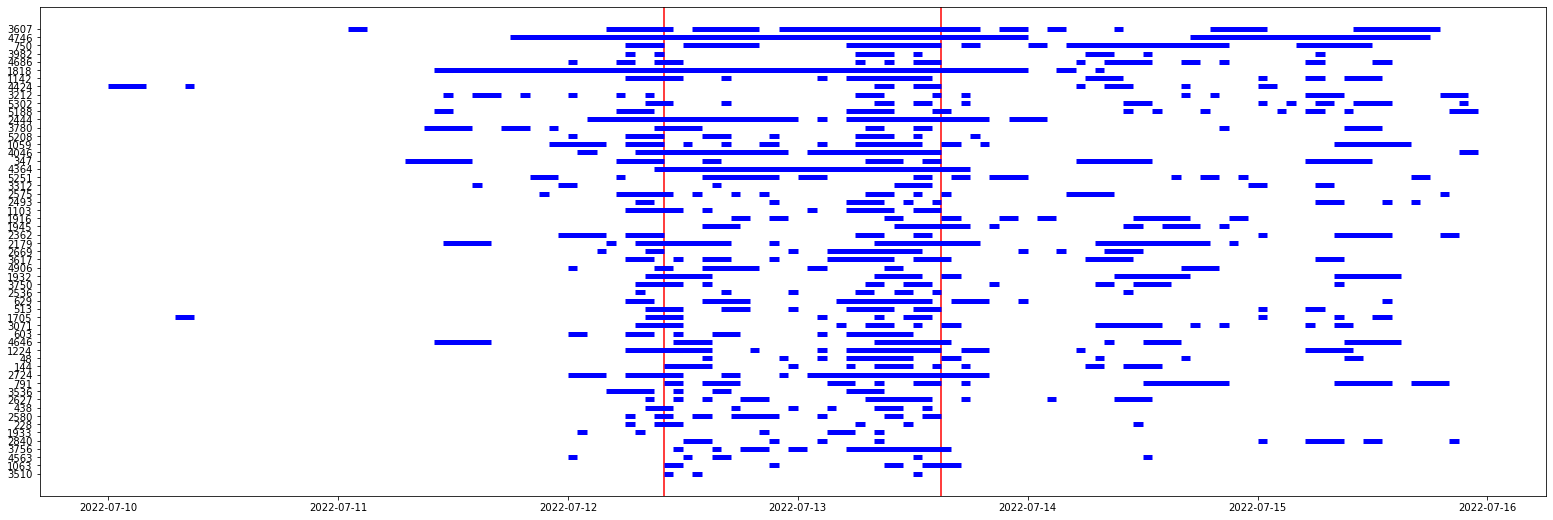

In [588]:
plot_clusters_lines(clusters2=all_sender_clusters_nn_statistics2, date_from=datetime.datetime(2022,7,10,0),date_to=datetime.datetime(2022,7,15,23))

In [567]:
#!pip install facets-overview

In [352]:
(datetime.datetime(2022,2,6,3) - datetime.datetime(2022,2,5,22)).seconds//3600

5

In [341]:
filter_dataframe(anomalies2,datetime.datetime(2022,2,6,0),datetime.datetime(2022,2,6,23))

,loss,close,threshold,anomaly,datetime
date,,,,,
2022-02-06-00,0.236959,-0.143894,0.217879,True,2022-02-06 00:00:00
2022-02-06-01,0.236961,-0.143894,0.217879,True,2022-02-06 01:00:00


In [639]:
np.clip(datetime.datetime(2022,7,10,3), datetime.datetime(2022,6,10,4),datetime.datetime(2022,6,10,7))

datetime.datetime(2022, 6, 10, 7, 0)

In [643]:
clip_cluster((datetime.datetime(2022,8,10,3), datetime.datetime(2022,8,16,3)),(datetime.datetime(2022,7,12,5), datetime.datetime(2022,7,13,23)))

In [644]:
def clip_cluster(cluster, window):
    start = np.clip(cluster[0], window[0], window[1])
    end   = np.clip(cluster[1], window[0], window[1])
    if start >= cluster[0] and end <=  cluster[1]:
        return start,end
    return None
    
def plot_cluster_lines(plt,clusters=None, color='blue', zorder=0 ,date_from=None, date_to=None):
    if clusters is not None:                
        for sender,date_clusters in clusters.items():    
            for key,month_clusters in date_clusters.items():
                if date_from is None or ((key[1] >= date_from.month) and (key[1] <= date_to.month)):
                    for cluster in month_clusters:
                        year=key[0]
                        month=key[1]
                        #_range = get_next_datestrings_of_timerange(dataframe=_anomalies,start=cluster[0],end=cluster[1])
                        clipped_cluster = clip_cluster(cluster[0:2], (date_from,date_to))
                        if date_from is None or clipped_cluster is not None:
                            plt.hlines(y = sender, xmin = clipped_cluster[0], xmax = clipped_cluster[1],color=color,zorder=zorder,lw=5)  
    
def plot_clusters_lines(clusters1=None,clusters2=None,expect=None, column_y='outcome',contains=None, date_from=None, date_to=None):
   
    #fig = plt.figure(figsize=(18,9))
    fig = plt.figure(figsize=(27,9))
    #fig.set_facecolor('#F2F2F2')
 
    plot_cluster_lines(plt,clusters=clusters1,color='red',zorder=5, date_from=date_from, date_to=date_to)
    plot_cluster_lines(plt,clusters=clusters2,color='blue',zorder=10, date_from=date_from, date_to=date_to)           

    if datetime.datetime(2022,7,12,10) >= date_from and datetime.datetime(2022,7,13,15) <= date_to:
        plt.axvline(x=datetime.datetime(2022,7,12,10), color="red",zorder=0)
        plt.axvline(x=datetime.datetime(2022,7,13,15), color="red",zorder=0)                

    plt.show()


def plot_monthly_clusters(anomalyEnc=None,test=None, scaler=None, anomalies=None, clusters=None,expect=None, column_y='outcome',contains=None, date_from=None, date_to=None):
   
    if anomalies is None:
        _anomalies = anomalyEnc.anomalies
    else:
        _anomalies = anomalies
    
    _threshold= pd.unique(_anomalies['threshold'])[0]
    
    _from = get_closest_datestring(datestring=date_from, dates = _anomalies['datetime'])
    _to = get_closest_datestring(datestring=date_to,dates = _anomalies['datetime'])
    _anomalies = filter_dataframe(_anomalies, date_from=_from, date_to=_to)
    
    if test is None:
        _test = anomalyEnc.test
    else:
        _test = test
        
    if scaler is None:
        _scaler = anomalyEnc.scaler
    else:
        _scaler = scaler    
    
    _max = np.max(scaler.inverse_transform(_anomalies[['close']] ))
    _max = 1000
    
    _test = filter_dataframe(_test,contains=contains, date_from=get_closest_datestring(datestring=date_from, dates = _test['datetime']), date_to=get_closest_datestring(datestring=date_to, dates = _test['datetime']))  
    _test1 = _test
    _test = _test[['close']]    
       
        
    #fig = plt.figure(figsize=(18,9))
    fig = plt.figure(figsize=(27,9))
    #fig.set_facecolor('#F2F2F2')
 
    for key,clusters in all_clusters.items():
        for cluster in clusters:
            year=key[0]
            month=key[1]
            #days
            #_range = get_next_datestrings_of_timerange(dataframe=_anomalies,start=(year, month, cluster[0],0),end=(year, month, cluster[1],23))   
            # hours
            _range = get_next_datestrings_of_timerange(dataframe=_anomalies,start=cluster[0],end=cluster[1])
            #plot_bounding_box(_range,_test,_scaler,color='yellow',max=_max) 
            #print(_range)
            #plt.hlines(y = 5000, xmin = _range[0], xmax = _range[1],color='blue')
            #plt.axhline(y = 5000, xmin = _range[0], xmax = _range[1])
            
            #'2022-01-03-14', '2022-01-05-21'
            #'2022-01-10-17', '2022-01-11-16'
    
    if expect is not None:
        plot_bounding_box(expect, _test, _scaler)
        #plot_bounding_lines(expect)
    
    plot_graph = True
    if plot_graph == True:
        # replace peaks by max value
        _t = _scaler.inverse_transform( _test)
        _t[_t>_max] = _max

        plt.plot(
          _test.index, 
          _t,  
          #_scaler.inverse_transform( _test),   
          label='msg count',
          alpha=0   
        );

    plot_anomalies = True    
    if plot_anomalies == True:    
        _a = inverse_transform_anomalies(scaler=_scaler,anomalies=_anomalies, column_y='close')
        #ax = scatterplot(_anomalies.index, _a, 'anomaly') 
        #ax.set_facecolor('#F2F2F2')   # set the background color of the plot area
        #plt.hlines(y = 200, xmin = _anomalies.index[0], xmax = _anomalies.index[10])
        #plt.hlines(y = 200, xmin ='2022-01-03-14', xmax = '2022-01-05-21')
    
    #skip_x = label_skip(len(_anomalies.index))
    #plt.xticks( _anomalies.index[0::skip_x],rotation=70,fontsize=10)
    #plt.yticks(fontsize=10)

    skip_x = label_skip(len(_test.index))
    plt.xticks( _test.index[0::skip_x],rotation=70,fontsize=10)
    plt.yticks(fontsize=10)
    
    # monthly lines
    for timestring in _test[_test.index.str.contains('-01-00')].index:
        plt.axvline(x=timestring, color="grey")   

        
   
    plt.show()




def plot_clusters(anomalyEnc=None,test=None, scaler=None, anomalies=None, clusters=None,expect=None, column_y='outcome',contains=None, date_from=None, date_to=None):
   
    if anomalies is None:
        _anomalies = anomalyEnc.anomalies
    else:
        _anomalies = anomalies
    
    _threshold= pd.unique(_anomalies['threshold'])[0]
    
    _from = get_closest_datestring(datestring=date_from, dates = _anomalies['datetime'])
    _to = get_closest_datestring(datestring=date_to,dates = _anomalies['datetime'])
    _anomalies = filter_dataframe(_anomalies, date_from=_from, date_to=_to)
    
    if test is None:
        _test = anomalyEnc.test
    else:
        _test = test
        
    if scaler is None:
        _scaler = anomalyEnc.scaler
    else:
        _scaler = scaler    
    
    _test = filter_dataframe(_test,contains=contains, date_from=get_closest_datestring(datestring=date_from, dates = _test['datetime']), date_to=get_closest_datestring(datestring=date_to, dates = _test['datetime']))  
    _test1 = _test
    _test = _test[['close']]    
        
    fig = plt.figure(figsize=(18,9))
    #fig.set_facecolor('#F2F2F2')
    
    for cluster in clusters:
        _range = get_next_datestrings_of_timerange(dataframe=_anomalies,start=(2022, 7, cluster[0],0),end=(2022, 7, cluster[1],23))   
        plot_bounding_box(_range,_test,_scaler,color='yellow') 
    
    if expect is not None:
        plot_bounding_box(expect, _test, _scaler)
        #plot_bounding_lines(expect)
       
    plt.plot(
      _test.index,  
      _scaler.inverse_transform( _test),   
      label='msg count'
    );

    _a = inverse_transform_anomalies(scaler=_scaler,anomalies=_anomalies, column_y='close')
    ax = scatterplot(_anomalies.index, _a, 'anomaly') 
    ax.set_facecolor('#F2F2F2')   # set the background color of the plot area
    
    skip_x = label_skip(len(_test.index))
    plt.xticks( _test.index[0::skip_x],rotation=70,fontsize=10)
    plt.yticks(fontsize=10)
    
    # monthly lines
    for timestring in _test[_test.index.str.contains('-01-00')].index:
        plt.axvline(x=timestring, color="grey")   

    plt.show()

### plot_anomalies

In [309]:
#plot_anomalies(anomalies=anomalies2,scaler=scaler,test=test, date_from='2022-01-01-00',date_to='2022-12-31-23')

In [321]:
def plot_bounding_lines(timerange,color="red"):
    hours= False
    if len(timerange[0].split('-')) == 4:
        hours = True
    if hours == False:
        plt.axvline(x=timerange[0], color=color)
    else:    
        plt.axvline(x=timerange[0], color=color)
        plt.axvline(x=timerange[1], color=color)

def plot_bounding_box(timerange,_test,scaler,color='g',max=None):  
    if isinstance(timerange[0],pd.Timestamp):
        # does not work because there is no datetime
        e1=_test.index.get_loc(_test[(_test['datetime'] == timerange[0])].index[0])
        e2=_test.index.get_loc(_test[(_test['datetime'] == timerange[1])].index[0])
    else:
        e1=_test.index.get_loc(timerange[0])
        e2=_test.index.get_loc(timerange[1])
    x = np.arange(e1,e2)
    _max = max
    if _max == None:
        _max = np.max(scaler.inverse_transform( _test))
    y1 = [0]*len(x)
    y2 = [_max]*len(x)
    plt.fill_between(x, y1, y2, facecolor=color, alpha=.3)
   

def plot_anomalies(anomalyEnc=None,test=None, scaler=None, anomalies=None, expect=None, column_y='outcome',contains=None, date_from=None, date_to=None):
   
    if anomalies is None:
        _anomalies = anomalyEnc.anomalies
    else:
        _anomalies = anomalies
    
    _threshold= pd.unique(_anomalies['threshold'])[0]
    
    _from = get_closest_datestring(datestring=date_from, dates = _anomalies['datetime'])
    _to = get_closest_datestring(datestring=date_to,dates = _anomalies['datetime'])
    _anomalies = filter_dataframe(_anomalies, date_from=_from, date_to=_to)
    
    if test is None:
        _test = anomalyEnc.test
    else:
        _test = test
        
    if scaler is None:
        _scaler = anomalyEnc.scaler
    else:
        _scaler = scaler    
        
    _test = filter_dataframe(_test,contains=contains, date_from=get_closest_datestring(datestring=date_from, dates = _test['datetime']), date_to=get_closest_datestring(datestring=date_to, dates = _test['datetime']))     
    #del _test["datetime"]    
    _test = _test[['close']]    
        
    fig = plt.figure(figsize=(18,9))
    #fig.set_facecolor('#F2F2F2')
    
    
    if expect is not None:
        plot_bounding_box(expect, _test, _scaler)
        #plot_bounding_lines(expect)
    
    
    #plt.plot(_test.index, _test[column_y])       
    plt.plot(
      _test.index,  
      _scaler.inverse_transform( _test),   
      label='msg count'
    );

    _a = inverse_transform_anomalies(scaler=_scaler,anomalies=_anomalies, column_y='close')
    ax = scatterplot(_anomalies.index, _a, 'anomaly') 
    ax.set_facecolor('#F2F2F2')   # set the background color of the plot area
    
    skip_x = label_skip(len(_test.index))
    plt.xticks( _test.index[0::skip_x],rotation=70,fontsize=10)
    plt.yticks(fontsize=10)
    
    # monthly lines
    for timestring in _test[_test.index.str.contains('-01-00')].index:
        plt.axvline(x=timestring, color="grey")   

    plt.show()

In [39]:
#_test = plot_anomalies(enc,date_from='2022-07-08-10',date_to='2022-07-14-15',expect=('2022-07-12-10','2022-07-13-15'))

In [40]:
#!ls -l /home/jovyan/work/output/experiment_anomaly_expect/

# Loop

In [41]:
def process(sender):
    pfall = df[df['CSENDERENDPOINTID'] == sender]
    #print('1')
    create_data(pfall)
    #print('2')
    train_models()
    save_models()
    update_thresholds()
    save_errors()

In [42]:
#global sender
#sender = senders[2]
#process(sender)

In [43]:
#_path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_hour/'

In [44]:
from os import listdir

def listdirectory(path=None,filter='.'):
    return [x for x in listdir(path) if not x.startswith(filter)]    

_path = '/home/jovyan/work/output/experiment_anomaly_expect/'
_files = listdirectory(path=_path)

In [45]:
#_files

In [46]:
#for sender in senders:
#    if str(sender) not in _files:
#        process(sender)

# Evaluate

### list directory

In [47]:
from os import listdir


def listdirectory(path=None,filter='.'):
    return [x for x in listdir(path) if not x.startswith(filter)]    

path = '/home/jovyan/work/output/experiment_anomaly_expect/' 
senders = listdirectory(path=path)

In [48]:
len(_files)
#_files[0], senders[0]

1676

In [49]:
!ls /home/jovyan/work/output/experiment_anomaly_expect/2580/anomalyEnc_hour

anomalies.parquet  scaler.pkl  test.parquet  test_score_df.parquet


# Functions

In [50]:
sender = senders[10]

from pickle import load
def load_data(experiment=None,path='/home/jovyan/work/output/experiment_anomaly_expect/',folder='anomalyEnc_CMESSAGETAT2_hour'):
    global scaler,anomalies,test,score
    _path = path + experiment + '/' + folder + '/'
    #_path = '/home/jovyan/work/output/experiment_anomaly_expect/' + str(sender) + '/anomalyEnc_hour/'
    scaler = load(open(_path + 'scaler.pkl', 'rb'))
    anomalies = pd.read_parquet(_path + 'anomalies.parquet')
    test  = pd.read_parquet(_path + 'test.parquet')
    score = pd.read_parquet(_path + 'test_score_df.parquet')
    return scaler,anomalies,test,score

In [51]:
def get_score_and_anomalies_with_threshold(threshold,score):
    score2 = score.copy()
    score2['threshold'] = threshold
    score2['anomaly'] = score2.loss >= score2.threshold
    anomalies2 = score2[score2.anomaly == True]
    add_datetime_column(anomalies2)
    return score2,anomalies2

def create_date_cluster(anomalies3):
    month_datelist = list(anomalies3['datetime'])
    _start=month_datelist[0].date().day
    _current = _start
    _count = 0
    _results=[]
    for date in month_datelist :
        if date.date().day - _current > 1:
                _results.append((_start,_current,_count))
                _start = date.date().day
                _count = 0
        _current = date.date().day  
        _count = _count + 1
    _results.append((_start,_current,_count))   
    return _results

def get_score_region(score):
    _from = get_closest_datestring(datestring='2022-07-12-10', dates = score['datetime'])
    _to = get_closest_datestring(datestring='2022-07-13-15',dates = score['datetime'])
    _score = filter_dataframe(score, date_from=_from, date_to=_to)
    return _score

def get_selected_thresholds(_score):
    _score['iclose'] = scaler.inverse_transform( _score[['close']]) 
    _iscore = _score[_score['iclose'] > 0.0000001]
    _min = min(_iscore.loss)
    _max = max(_iscore.loss)
    _avg = (_max - _min)/2 + _min
    return _min,_max,_avg

def get_number_anomalies_with_threshold(_min,score):
    score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)
    anomalies2['iclose'] = scaler.inverse_transform( anomalies2[['close']]) 
    anomalies3 = anomalies2[anomalies2.index.str.contains('2022-07')]
    cluster = create_date_cluster(anomalies3)
    return len(anomalies2), len(anomalies2[anomalies2['iclose'] > 0.0000001]), len(anomalies3), len(anomalies3[anomalies3['iclose'] > 0.0000001]), cluster 


def get_selected_number_anomalies(score):
    try:
        add_datetime_column(score)
        _score = get_score_region(score)
        _min,_max,_avg = get_selected_thresholds(_score)
        _lmin = get_number_anomalies_with_threshold(_min,score)
        _lmax = get_number_anomalies_with_threshold(_max,score)
        _lavg = get_number_anomalies_with_threshold(_avg,score)
        return _lmin,_lmax,_lavg,  len(get_score_and_anomalies_with_threshold(_score.loss[0],score)[1])
    except Exception as exception:
        #print(exception)
        return (0,0),(0,0),(0,0),  0
    
    #_min = min(_score.loss)
    #_max = max(_score.loss)
    #return len(get_score_and_anomalies_with_threshold(_min,_score)[1]), len(get_score_and_anomalies_with_threshold(_max,_score)[1]), len(get_score_and_anomalies_with_threshold(_score.loss[0],_score)[1])

In [52]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
#pd.options.mode.chained_assignment = "warn"

def create_statistics(senders,folder='anomalyEnc_CMESSAGETAT2_hour'):
    global statistics
    statistics = pd.DataFrame(columns=['min0','max0','avg0','start', 'min','max','avg', 'min_07','max_07','avg_07', 'ccmin_07','ccmax_07','ccavg_07','cmin_07','cmax_07','cavg_07', 'amin','amax','astart','test_not_null','filled','values'])

    for sender in senders:
        try:
            scaler,anomalies,test,score = load_data(experiment=str(sender),folder=folder)
            _lmin,_lmax,_lavg, _lstart = get_selected_number_anomalies(score)
            
            _result =scaler.inverse_transform( test[['close']]) 
            _values_test_not_null = len(_result[_result > 0.0000001])
            _filled = round(1 - _values_test_not_null / len(_result),3)

            add_datetime_column(score)
            _region = get_score_region(score)
            _result = scaler.inverse_transform( _region[['close']])
            #values = len(_result[_result != 0])
            values = len(_result[_result > 0.0000001])

            statistics.loc[sender] = _lmin[0],_lmax[0],_lavg[0],_lstart, _lmin[1],_lmax[1],_lavg[1],_lmin[3],_lmax[3],_lavg[3],\
            len(_lmin[4]),len(_lmax[4]),len(_lavg[4]), _lmin[4],_lmax[4],_lavg[4],\
            _lmin[0]/len(test),_lmax[0]/len(test),_lavg[0]/len(test),_values_test_not_null,_filled,values
        except Exception as exception: 
            print(exception)
            pass
        
    statistics['min'] = statistics['min'].astype(int)
    statistics['max'] = statistics['max'].astype(int)
    statistics['avg'] = statistics['avg'].astype(int)
    statistics['min0'] = statistics['min0'].astype(int)
    statistics['max0'] = statistics['max0'].astype(int)
    statistics['avg0'] = statistics['avg0'].astype(int)
    statistics['start'] = statistics['start'].astype(int) 
    statistics['values'] = statistics['values'].astype(int)  
    statistics['test_not_null'] = statistics['test_not_null'].astype(int)
    return statistics       

#_statistics1 = create_statistics(senders)
#_statistics.to_parquet('/home/jovyan/work/output/statistics2.parquet')

# Run

## create statistics

In [ ]:
_statistics1 = create_statistics(senders,folder='anomalyEnc_CMESSAGETAT2_hour')
_statistics1.to_parquet('/home/jovyan/work/output/statistics_CMESSAGETAT2_hour.parquet')

In [ ]:
_statistics1 = create_statistics(senders[:100],folder='anomalyEnc_CMESSAGETAT2_hour')

In [820]:
#_statistics1.to_parquet('/home/jovyan/work/output/statistics_CMESSAGETAT2_hour1.parquet')

In [ ]:
_statistics2 = create_statistics(senders,folder='anomalyEnc_hour')
_statistics2.to_parquet('/home/jovyan/work/output/statistics_anomalyEnc_hour.parquet')

In [644]:
_df['test_not_null'] = _df['test_not_null'].astype(int)

In [812]:
!ls /home/jovyan/work/output/experiment_anomaly_expect/10

anomalyEnc_CMESSAGETAT2_hour  anomalyEnc_hour


In [810]:
create_statistics(senders[:1],folder='anomalyEnc_CMESSAGETAT2_hour')
create_statistics(senders[:1],folder='anomalyEnc_hour')

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
2580,2851,1042,1520,2523,1489,554,802,44,1,16,...,1,"[(1, 1, 8), (8, 9, 22), (12, 13, 40), (16, 16,...","[(12, 13, 4)]","[(12, 13, 24)]",0.186916,0.077381,0.186916,8195,0.544,21


In [813]:
create_statistics(senders[:1],folder='anomalyEnc_hour')

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
2580,2385,580,993,1224,1242,304,521,72,10,33,...,2,"[(1, 2, 25), (11, 15, 92), (18, 18, 11), (27, ...","[(1, 2, 23), (13, 13, 1)]","[(1, 2, 24), (13, 15, 44)]",0.186916,0.077381,0.186916,8195,0.544,21


In [746]:
_df = create_statistics(_selected_senders[:20])
#_df = create_statistics(senders[:10])

In [745]:
create_statistics(_selected_senders[:1])

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
5212,16972,491,1046,16899,15720,453,981,628,1,24,...,1,"[(1, 21, 485), (23, 31, 189)]","[(13, 13, 1)]","[(12, 13, 24)]",0.186667,0.077278,0.186667,16721,0.071,30


In [822]:
_statistics1

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
2580,2851,1042,1520,2523,1489,554,802,44,1,16,...,1,"[(1, 1, 8), (8, 9, 22), (12, 13, 40), (16, 16,...","[(12, 13, 4)]","[(12, 13, 24)]",0.186916,0.077381,0.186916,8195,0.544,21
618,653,531,629,529,26,21,25,4,2,3,...,2,"[(11, 14, 72), (22, 23, 24)]","[(11, 14, 48)]","[(11, 14, 48), (22, 23, 24)]",0.186916,0.077381,0.186916,699,0.961,2
3231,12533,796,3032,3787,879,83,281,30,2,5,...,2,"[(1, 21, 412), (27, 31, 97)]","[(13, 14, 17)]","[(2, 2, 4), (12, 16, 50)]",0.186916,0.077381,0.186916,1225,0.932,5
4105,17952,17952,17952,17952,329,329,329,1,1,1,...,1,"[(1, 31, 744)]","[(1, 31, 744)]","[(1, 31, 744)]",0.186916,0.077381,0.186916,329,0.982,1
1964,5652,577,1585,5646,547,74,204,31,2,7,...,3,"[(5, 5, 1), (9, 10, 3), (12, 15, 86), (17, 29,...","[(13, 13, 11)]","[(12, 15, 33), (19, 20, 20), (27, 27, 1)]",0.186916,0.077381,0.186916,1372,0.924,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,12339,12339,12339,12359,891,891,891,40,40,40,...,1,"[(1, 31, 638)]","[(1, 31, 638)]","[(1, 31, 638)]",0.186916,0.077381,0.186916,1213,0.933,1
4723,4263,3345,3807,3345,348,277,306,12,7,9,...,5,"[(1, 2, 24), (4, 7, 67), (12, 16, 63), (18, 19...","[(1, 2, 24), (4, 5, 24), (12, 12, 1), (15, 16,...","[(1, 2, 24), (4, 6, 43), (12, 13, 24), (15, 16...",0.186916,0.077381,0.186916,1140,0.937,3
1386,17094,4360,10615,4360,2871,794,1866,148,44,127,...,1,"[(1, 31, 744)]","[(2, 2, 2), (5, 8, 44), (10, 16, 69), (18, 21,...","[(1, 31, 660)]",0.186916,0.077381,0.186916,3040,0.831,7
1751,14297,4344,6005,14296,997,498,597,34,1,5,...,3,"[(1, 31, 708)]","[(12, 13, 21)]","[(2, 5, 48), (12, 15, 48), (22, 23, 24)]",0.186916,0.077381,0.186916,1177,0.935,3


#### _df

In [747]:
#_df.sort_values('test_not_null',ascending=False)
_df.sort_values('min_07',ascending=True)

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
2724,3283,1720,2318,2105,2272,1167,1608,85,2,38,...,4,"[(1, 1, 6), (5, 6, 30), (12, 14, 52), (19, 19,...","[(6, 6, 1), (12, 12, 1)]","[(1, 1, 4), (6, 6, 8), (12, 13, 29), (19, 19, ...",0.186170,0.077072,0.186170,9372,0.481,25
4364,9279,2816,4820,9279,9231,2803,4790,170,1,35,...,2,"[(6, 10, 51), (12, 13, 34), (16, 17, 17), (19,...","[(13, 13, 1)]","[(7, 7, 11), (12, 13, 24)]",0.186667,0.077278,0.186667,17917,0.005,30
4046,8134,1593,3602,3349,6927,1359,2964,175,7,42,...,6,"[(1, 3, 47), (7, 10, 49), (12, 13, 36), (15, 1...","[(2, 3, 3), (9, 9, 1), (13, 13, 1), (31, 31, 9)]","[(1, 3, 14), (7, 7, 2), (9, 9, 6), (12, 13, 20...",0.186916,0.077381,0.186916,16226,0.097,29
1818,12978,8659,10647,12978,12887,8576,10560,218,81,133,...,4,"[(6, 8, 37), (11, 14, 68), (20, 22, 62), (24, ...","[(7, 8, 23), (11, 12, 25), (21, 22, 9), (27, 2...","[(6, 8, 35), (11, 13, 36), (20, 22, 38), (27, ...",0.186170,0.077072,0.186170,17949,0.005,30
266,13362,2251,7187,8605,7163,1076,3743,308,9,104,...,1,"[(1, 31, 581)]","[(3, 3, 1), (5, 10, 17), (13, 17, 21), (24, 25...","[(2, 31, 234)]",0.186667,0.077278,0.186667,8109,0.549,26
3607,11219,6853,8595,9472,8045,5025,6208,321,6,93,...,5,"[(1, 2, 39), (4, 9, 119), (11, 18, 104), (21, ...","[(1, 2, 5), (13, 13, 1)]","[(1, 2, 31), (4, 9, 41), (12, 15, 23), (23, 23...",0.212121,0.087816,0.212121,9958,0.371,28
3753,3815,71,159,3786,2802,57,119,346,1,23,...,1,"[(1, 2, 26), (4, 9, 104), (11, 16, 128), (18, ...","[(12, 12, 1)]","[(12, 13, 24)]",0.564516,0.233703,0.564516,3554,0.403,29
862,15943,9914,10877,15943,7735,1816,2751,432,9,44,...,2,"[(1, 22, 357), (24, 24, 5), (27, 31, 79)]","[(13, 13, 1), (30, 30, 8)]","[(12, 13, 23), (29, 30, 24)]",0.186916,0.077381,0.186916,9738,0.458,29
2559,2463,723,1141,1929,2244,606,994,435,2,67,...,5,"[(1, 1, 9), (4, 16, 233), (19, 23, 98), (26, 3...","[(13, 13, 1), (29, 29, 1)]","[(5, 5, 7), (7, 8, 11), (12, 13, 24), (22, 22,...",0.453074,0.187567,0.453074,5438,0.267,30
1243,16863,417,1567,16856,11699,325,1155,437,1,21,...,1,"[(1, 31, 573)]","[(12, 12, 1)]","[(12, 13, 24)]",0.186667,0.077278,0.186667,12702,0.294,27


In [617]:
for index, row in _df.iterrows():
    _statistics.loc[index] = row

In [603]:
_statistics.index

Index(['2580', '1884', '618', '3231', '4105', '1964', '1734', '1747', '1453',
       '4570',
       ...
       '5004', '3871', '5271', '4493', '414', '627', '3733', '5269', '2096',
       '1078'],
      dtype='object', length=638)

In [329]:
_anomaly_counts


In [335]:
add_datetime_column(score)
_region = get_score_region(score)
_result = scaler.inverse_transform( _region[['close']])
values = len(_result[_result != 0])

In [336]:
values

2

## load statistics

In [54]:
_statistics = pd.read_parquet('/home/jovyan/work/output/statistics_CMESSAGETAT2_hour.parquet')

In [604]:
_statistics_anomalyEnc_hour = pd.read_parquet('/home/jovyan/work/output/statistics_anomalyEnc_hour.parquet')

In [607]:
_statistics
_statistics_anomalyEnc_hour.loc[_statistics3.index]

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
3756,12426,5478,8120,7966,8240,3864,5677,420,137,280,...,4,"[[1, 16, 315], [18, 31, 291]]","[[1, 2, 44], [4, 4, 2], [6, 9, 49], [12, 13, 6...","[[1, 9, 147], [12, 16, 80], [18, 23, 78], [25,...",0.685762,0.302318,0.448124,10465,0.422,22
4364,10415,2608,4700,4604,10402,2602,4694,491,140,235,...,5,"[[1, 2, 45], [4, 23, 342], [25, 30, 104]]","[[1, 2, 6], [4, 5, 5], [7, 9, 55], [11, 11, 3]...","[[1, 2, 24], [4, 16, 130], [18, 23, 44], [25, ...",0.578611,0.144889,0.261111,17918,0.005,30
4046,9320,2527,5088,8497,8035,2046,4260,215,34,80,...,6,"[[1, 7, 67], [9, 31, 186]]","[[1, 4, 29], [9, 9, 5], [13, 13, 1], [30, 31, ...","[[1, 4, 46], [6, 6, 1], [9, 13, 21], [15, 17, ...",0.518469,0.140576,0.283044,16226,0.097,29
1818,9611,3498,6058,5254,9565,3478,6023,297,56,133,...,5,"[[1, 2, 7], [4, 8, 75], [11, 15, 82], [18, 22,...","[[4, 8, 24], [11, 15, 20], [18, 18, 3], [20, 2...","[[1, 2, 5], [4, 8, 44], [11, 15, 46], [18, 21,...",0.532524,0.193816,0.335660,17949,0.005,30
4746,4255,592,1856,1809,3954,557,1745,269,21,145,...,5,"[[1, 1, 17], [5, 6, 26], [8, 8, 7], [11, 16, 9...","[[5, 6, 12], [12, 12, 1], [28, 29, 10]]","[[1, 1, 11], [5, 6, 22], [11, 15, 62], [19, 20...",0.234823,0.032671,0.102428,13284,0.267,30


In [53]:
#!ls /home/jovyan/work/output/

enc
experiment_anomaly_expect
experiment_anomaly_expect_sender_receiver
filtered_clusters_statistics_anomalyEnc_hour.parquet
senders_files.txt
sla_enc_all_2.parquet
sla_enc_all_3.parquet
sla_enc_all_4.parquet
sla_enc_all_5.parquet
sla_enc_all.parquet
statistics1.parquet
statistics_anomalyEnc_hour.parquet
statistics_CMESSAGETAT2_hour1.parquet
statistics_CMESSAGETAT2_hour.parquet
statistics.parquet


### trial

In [58]:
_selected_senders = _statistics.sort_values('values',ascending=False).index

In [61]:
_statistics.sort_values('values',ascending=False).iloc[0:10]

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
97,7924,1342,2641,7924,7561,1108,2365,594,47,157,...,6,"[[1, 4, 90], [6, 13, 181], [15, 26, 236], [28,...","[[3, 3, 18], [13, 13, 1], [17, 17, 7], [30, 31...","[[2, 4, 39], [12, 13, 24], [16, 18, 32], [21, ...",0.575203,0.097416,0.191710,9235,0.330,30
3516,17960,11101,15513,12445,13904,7936,11697,582,162,373,...,2,"[[1, 31, 695]]","[[3, 12, 87], [15, 28, 122], [30, 31, 11]]","[[1, 1, 1], [3, 31, 466]]",0.991170,0.612638,0.856126,14043,0.225,30
4746,9633,789,2965,9633,7872,593,2420,312,1,96,...,5,"[[1, 2, 31], [4, 9, 51], [11, 16, 90], [18, 23...","[[4, 4, 1], [12, 12, 1]]","[[1, 2, 6], [4, 9, 18], [11, 16, 35], [18, 23,...",0.531623,0.043543,0.163631,13281,0.267,30
3193,9518,5343,7659,6162,9228,5109,7393,705,422,559,...,2,"[[1, 31, 716]]","[[2, 7, 84], [9, 12, 66], [14, 19, 74], [21, 3...","[[1, 19, 333], [21, 31, 236]]",0.953325,0.535156,0.767127,9692,0.029,30
2559,2463,723,1141,1929,2244,606,994,435,2,67,...,5,"[[1, 1, 9], [4, 16, 233], [19, 23, 98], [26, 3...","[[13, 13, 1], [29, 29, 1]]","[[5, 5, 7], [7, 8, 11], [12, 13, 24], [22, 22,...",0.332120,0.097492,0.153857,5438,0.267,30
21,17653,1107,1715,14270,17640,1107,1715,743,1,2,...,1,"[[1, 31, 743]]","[[12, 12, 1]]","[[12, 12, 2]]",0.974227,0.061093,0.094647,18104,0.001,30
2554,12678,4513,7419,12678,12270,4326,7140,534,129,295,...,5,"[[1, 31, 558]]","[[1, 6, 64], [8, 11, 38], [13, 13, 1], [15, 15...","[[1, 13, 183], [15, 18, 56], [22, 24, 31], [26...",0.700597,0.249392,0.409980,17568,0.029,30
4767,13290,9333,9929,9654,13211,9262,9854,416,18,68,...,4,"[[1, 31, 416]]","[[8, 8, 4], [12, 12, 1], [26, 27, 13]]","[[7, 8, 15], [12, 13, 17], [22, 23, 18], [26, ...",0.801375,0.562771,0.598710,16444,0.008,30
2913,16436,135,462,16210,16317,134,461,641,1,24,...,1,"[[1, 19, 426], [21, 31, 215]]","[[12, 12, 1]]","[[12, 13, 24]]",0.904668,0.007431,0.025429,18046,0.007,30
4000,8175,282,594,4933,8084,278,584,744,1,24,...,1,"[[1, 31, 744]]","[[12, 12, 1]]","[[12, 13, 24]]",0.474408,0.016365,0.034471,17082,0.009,30


In [62]:
_statistics.sort_values('filled',ascending=True).iloc[0:10]

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
21,17653,1107,1715,14270,17640,1107,1715,743,1,2,...,1,"[[1, 31, 743]]","[[12, 12, 1]]","[[12, 12, 2]]",0.974227,0.061093,0.094647,18104,0.001,30
2730,3132,109,297,2770,3115,103,290,334,1,24,...,1,"[[1, 7, 110], [9, 9, 1], [12, 22, 139], [24, 2...","[[13, 13, 1]]","[[12, 13, 24]]",0.541494,0.018845,0.051349,5765,0.003,30
4364,9279,2816,4820,9279,9231,2803,4790,170,1,35,...,2,"[[6, 10, 51], [12, 13, 34], [16, 17, 17], [19,...","[[13, 13, 1]]","[[7, 7, 11], [12, 13, 24]]",0.515500,0.156444,0.267778,17917,0.005,30
1818,12978,8659,10647,12978,12887,8576,10560,218,81,133,...,4,"[[6, 8, 37], [11, 14, 68], [20, 22, 62], [24, ...","[[7, 8, 23], [11, 12, 25], [21, 22, 9], [27, 2...","[[6, 8, 35], [11, 13, 36], [20, 22, 38], [27, ...",0.719082,0.479776,0.589927,17949,0.005,30
2913,16436,135,462,16210,16317,134,461,641,1,24,...,1,"[[1, 19, 426], [21, 31, 215]]","[[12, 12, 1]]","[[12, 13, 24]]",0.904668,0.007431,0.025429,18046,0.007,30
4767,13290,9333,9929,9654,13211,9262,9854,416,18,68,...,4,"[[1, 31, 416]]","[[8, 8, 4], [12, 12, 1], [26, 27, 13]]","[[7, 8, 15], [12, 13, 17], [22, 23, 18], [26, ...",0.801375,0.562771,0.598710,16444,0.008,30
4000,8175,282,594,4933,8084,278,584,744,1,24,...,1,"[[1, 31, 744]]","[[12, 12, 1]]","[[12, 13, 24]]",0.474408,0.016365,0.034471,17082,0.009,30
3471,15927,9709,13654,10944,15761,9576,13498,718,116,516,...,1,"[[1, 31, 720]]","[[1, 4, 47], [7, 7, 1], [12, 12, 1], [17, 19, ...","[[1, 31, 518]]",0.880139,0.536527,0.754531,17923,0.010,29
2447,9484,3699,5615,9484,9373,3634,5533,654,10,140,...,6,"[[1, 31, 659]]","[[13, 13, 1], [16, 17, 2], [24, 24, 3], [30, 3...","[[6, 8, 28], [11, 14, 39], [16, 17, 25], [19, ...",0.934200,0.364362,0.553093,10037,0.011,30
285,2201,26,117,2201,2156,26,105,288,1,23,...,1,"[[2, 10, 125], [12, 14, 53], [16, 17, 29], [20...","[[12, 12, 1]]","[[12, 13, 23]]",0.485229,0.005732,0.025794,4482,0.012,30


In [619]:
_statistics.loc[senders[:5]]

,min0,max0,avg0,start,min,max,avg,amin,amax,astart,filled,values
2580,2851,1042,1520,2523,1489,554,802,0.186916,0.077381,0.186916,0.544,21
1884,0,0,0,17784,0,0,0,0.188679,0.078111,0.188679,0.993,0
618,653,531,629,529,26,21,25,0.186916,0.077381,0.186916,0.961,2
3231,12533,796,3032,3787,879,83,281,0.186916,0.077381,0.186916,0.932,5
4105,17952,17952,17952,17952,329,329,329,0.186916,0.077381,0.186916,0.982,1


#### load

In [887]:
#!ls /home/jovyan/work/output/experiment_anomaly_expect_sender_receiver/2580_1414

from os import listdir
def listdirectory(path=None,filter='.'):
    return [x for x in listdir(path) if not x.startswith(filter)]    
_path = '/home/jovyan/work/output/experiment_anomaly_expect_sender_receiver/'
_files = listdirectory(path=_path)

scaler,anomalies,test,score = load_data(experiment=_files[2],path='/home/jovyan/work/output/experiment_anomaly_expect_sender_receiver/',folder='anomalyEnc_CMESSAGETAT2_hour')
add_datetime_column(score)
_score = get_score_region(score)
_min,_max,_avg = get_selected_thresholds(_score)
score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)

_min,_max,_avg

(0.14161961889216076, 0.39607326615663, 0.2688464425243954)

In [893]:
len(_files)

5

In [70]:
import datetime

In [488]:
sender=_statistics3.index[0]
#sender=_statistics2.index[1]
#sender=_statistics1.loc[filtered_clusters_senders].sort_values('min_07').index[10]
#sender = filtered_clusters[0][0]
#sender = _df.sort_values('min_07',ascending=True).index[2]
#sender = _df.sort_values('test_not_null',ascending=False).index[16]
#sender = senders[0]
#sender = _selected_senders[0]
scaler,anomalies,test,score = load_data(str(sender))
add_datetime_column(score)

_score = get_score_region(score)
_min,_max,_avg = get_selected_thresholds(_score)
#anomalies2=anomalies
#score2=score 
score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)

_min,_max,_avg

(0.01411827002804786, 0.015979748586731447, 0.015049009307389654)

#### create all clusters

In [613]:
def load_score_and_anomalies_with_min_threshold(sender,path='/home/jovyan/work/output/experiment_anomaly_expect/',folder='anomalyEnc_CMESSAGETAT2_hour'):
    scaler,anomalies,test,score = load_data(experiment=str(sender),path=path,folder=folder)
    add_datetime_column(score)
    _score = get_score_region(score)
    _min,_max,_avg = get_selected_thresholds(_score)
    score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)
    return scaler,anomalies2,test,score2

In [611]:
_statistics3__anomalyEnc_hour =  _statistics_anomalyEnc_hour.loc[_statistics3.index]
sender=_statistics3.index[0]
load_score_and_anomalies_with_min_threshold(sender,folder='anomalyEnc_hour')

In [617]:
#all_sender_clusters_statistics2 = all_sender_clusters
#all_sender_clusters_statistics3 = all_sender_clusters
#all_sender_clusters_nn_statistics3 = all_sender_clusters_nn
#all_sender_clusters_nn_statistics2 = all_sender_clusters_nn
all_sender_clusters_anomalyEnc_hour_statistics3 = create_all_sender_clusters(_statistics3__anomalyEnc_hour,folder='anomalyEnc_hour')
all_sender_clusters_anomalyEnc_hour_nn_statistics3 = create_all_sender_clusters_nn(_statistics3__anomalyEnc_hour,folder='anomalyEnc_hour')

In [600]:
scaler,anomalies2,test,score2 = load_score_and_anomalies_with_min_threshold(1933)

In [619]:
def create_all_sender_clusters(_statistics3,path='/home/jovyan/work/output/experiment_anomaly_expect/',folder='anomalyEnc_CMESSAGETAT2_hour'):
    all_sender_clusters={}

    for sender in _statistics3.index:
        try:
            scaler,anomalies2,test,score2 = load_score_and_anomalies_with_min_threshold(sender,path=path,folder=folder)
            all_sender_clusters[sender] = create_all_clusters(anomalies2,year=2022)
        except Exception as exception:
            print(sender)
            
    return all_sender_clusters        

def create_all_sender_clusters_nn(_statistics3,path='/home/jovyan/work/output/experiment_anomaly_expect/',folder='anomalyEnc_CMESSAGETAT2_hour'):
    all_sender_clusters={}

    for sender in _statistics3.index:
        try:
            scaler,anomalies2,test,score2 = load_score_and_anomalies_with_min_threshold(sender,path=path,folder=folder)
            anomalies2_not_null,test_not_null = remove_null_values(anomalies2,test)
            all_sender_clusters[sender] = create_all_clusters(anomalies2_not_null,year=2022)
        except Exception as exception:
            print(sender)
            
    return all_sender_clusters        

In [ ]:
all_sender_clusters_nn={}

for sender in _statistics2.index:
    try:
        score2,anomalies2 = load_score_and_anomalies_with_min_threshold(sender)
        anomalies2_not_null,test_not_null = remove_null_values(anomalies2,test)
        all_sender_clusters_nn[sender] = create_all_clusters(anomalies2_not_null,year=2022)
    except Exception as exception:
        print(sender)

In [475]:
all_sender_clusters={}

for sender in _statistics3.index:
    try:
        score2,anomalies2 = load_score_and_anomalies_with_min_threshold(sender)
        all_sender_clusters[sender] = create_all_clusters(anomalies2,year=2022)
    except Exception as exception:
        print(sender)

In [550]:
sender=_statistics3 .index[0]
score2,anomalies2 = load_score_and_anomalies_with_min_threshold(sender)
anomalies2_not_null,test_not_null = remove_null_values(anomalies2,test)
_clusters_nn = create_all_clusters(anomalies2_not_null,year=2022)
_clusters = create_all_clusters(anomalies2,year=2022)

In [ ]:
all_sender_clusters_nn={}

for sender in _statistics2.index:
    try:
        score2,anomalies2 = load_score_and_anomalies_with_min_threshold(sender)
        anomalies2_not_null,test_not_null = remove_null_values(anomalies2,test)
        all_sender_clusters_nn[sender] = create_all_clusters(anomalies2_not_null,year=2022)
    except Exception as exception:
        print(sender)

In [562]:
#all_sender_clusters_statistics2 = all_sender_clusters
#all_sender_clusters_statistics3 = all_sender_clusters
#all_sender_clusters_nn_statistics3 = all_sender_clusters_nn
#all_sender_clusters_nn_statistics2 = all_sender_clusters_nn

In [473]:
#all_sender_clusters

In [847]:
_statistics1.loc[sender]

min0                                                          2851
max0                                                          1042
avg0                                                          1520
start                                                         2523
min                                                           1489
max                                                            554
avg                                                            802
min_07                                                          44
max_07                                                           1
avg_07                                                          16
ccmin_07                                                         5
ccmax_07                                                         1
ccavg_07                                                         1
cmin_07          [(1, 1, 8), (8, 9, 22), (12, 13, 40), (16, 16,...
cmax_07                                              [(12, 13,

#### clusters

In [806]:
#clusters =_df.loc[sender]['cmin_07']
#clusters

[(6, 10, 51), (12, 13, 34), (16, 17, 17), (19, 24, 68)]

In [63]:
def get_cluster(clusters=None, values = [12, 13]):
    for cluster in clusters:
        if any(val >= cluster[0] and val <= cluster[1] for val in values):
            return cluster
    return None    
        
#get_cluster(clusters)        

In [64]:
filtered_clusters=[]
for index, row in _statistics.iterrows():
    cluster = get_cluster(row['cmin_07'])
    if cluster[0] > 10:
        filtered_clusters.append((index,cluster))

In [65]:
filtered_clusters_senders =  [cluster[0] for cluster in filtered_clusters]

In [67]:
len(filtered_clusters_senders)

287

In [68]:
_statistics2 = _statistics.loc[filtered_clusters_senders]
_statistics2 = _statistics2[_statistics2['values'] > 10].sort_values('min_07')
_statistics2

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
3510,3677,973,1749,3664,609,168,306,19,1,6,...,1,"[[1, 1, 11], [7, 8, 26], [12, 14, 44], [18, 21...","[[12, 13, 12]]","[[12, 13, 25]]",0.202914,0.053695,0.096518,1620,0.911,11
1063,2349,711,1287,2181,392,117,213,20,4,10,...,2,"[[8, 9, 5], [12, 14, 54], [20, 20, 5], [28, 28...","[[13, 14, 20]]","[[12, 14, 39], [28, 28, 3]]",0.130153,0.039395,0.071310,2189,0.879,12
4563,4281,1443,2188,2818,1905,705,1018,22,1,4,...,1,"[[8, 8, 2], [11, 14, 52]]","[[12, 12, 1]]","[[12, 13, 10]]",0.237833,0.080167,0.121556,7281,0.595,13
3756,3121,2022,2445,3846,2193,1427,1726,24,1,6,...,1,"[[12, 13, 29], [20, 20, 1]]","[[13, 13, 3]]","[[12, 13, 9]]",0.172241,0.111589,0.134934,10464,0.423,22
2840,3613,281,641,3631,1659,119,270,39,1,10,...,1,"[[5, 5, 10], [12, 16, 63], [26, 26, 17], [30, ...","[[12, 13, 8]]","[[12, 13, 24]]",0.200188,0.015570,0.035516,6526,0.638,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2201,26,117,2201,2156,26,105,288,1,23,...,1,"[[2, 10, 125], [12, 14, 53], [16, 17, 29], [20...","[[12, 12, 1]]","[[12, 13, 23]]",0.485229,0.005732,0.025794,4482,0.012,30
4746,9633,789,2965,9633,7872,593,2420,312,1,96,...,5,"[[1, 2, 31], [4, 9, 51], [11, 16, 90], [18, 23...","[[4, 4, 1], [12, 12, 1]]","[[1, 2, 6], [4, 9, 18], [11, 16, 35], [18, 23,...",0.531623,0.043543,0.163631,13281,0.267,30
3607,11219,6853,8595,9472,8045,5025,6208,321,6,93,...,5,"[[1, 2, 39], [4, 9, 119], [11, 18, 104], [21, ...","[[1, 2, 5], [13, 13, 1]]","[[1, 2, 31], [4, 9, 41], [12, 15, 23], [23, 23...",0.708270,0.432639,0.542614,9958,0.371,28
2730,3132,109,297,2770,3115,103,290,334,1,24,...,1,"[[1, 7, 110], [9, 9, 1], [12, 22, 139], [24, 2...","[[13, 13, 1]]","[[12, 13, 24]]",0.541494,0.018845,0.051349,5765,0.003,30


In [81]:
_statistics3 = _statistics2[_statistics2['test_not_null'] > 10000]
_statistics3

,min0,max0,avg0,start,min,max,avg,min_07,max_07,avg_07,...,ccavg_07,cmin_07,cmax_07,cavg_07,amin,amax,astart,test_not_null,filled,values
3756,3121,2022,2445,3846,2193,1427,1726,24,1,6,...,1,"[[12, 13, 29], [20, 20, 1]]","[[13, 13, 3]]","[[12, 13, 9]]",0.172241,0.111589,0.134934,10464,0.423,22
4364,9279,2816,4820,9279,9231,2803,4790,170,1,35,...,2,"[[6, 10, 51], [12, 13, 34], [16, 17, 17], [19,...","[[13, 13, 1]]","[[7, 7, 11], [12, 13, 24]]",0.515500,0.156444,0.267778,17917,0.005,30
4046,8134,1593,3602,3349,6927,1359,2964,175,7,42,...,6,"[[1, 3, 47], [7, 10, 49], [12, 13, 36], [15, 1...","[[2, 3, 3], [9, 9, 1], [13, 13, 1], [31, 31, 9]]","[[1, 3, 14], [7, 7, 2], [9, 9, 6], [12, 13, 20...",0.452492,0.088618,0.200378,16226,0.097,29
1818,12978,8659,10647,12978,12887,8576,10560,218,81,133,...,4,"[[6, 8, 37], [11, 14, 68], [20, 22, 62], [24, ...","[[7, 8, 23], [11, 12, 25], [21, 22, 9], [27, 2...","[[6, 8, 35], [11, 13, 36], [20, 22, 38], [27, ...",0.719082,0.479776,0.589927,17949,0.005,30
4746,9633,789,2965,9633,7872,593,2420,312,1,96,...,5,"[[1, 2, 31], [4, 9, 51], [11, 16, 90], [18, 23...","[[4, 4, 1], [12, 12, 1]]","[[1, 2, 6], [4, 9, 18], [11, 16, 35], [18, 23,...",0.531623,0.043543,0.163631,13281,0.267,30


In [865]:
#_statistics2.to_parquet('/home/jovyan/work/output/filtered_clusters_statistics_anomalyEnc_hour.parquet')

In [757]:
score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)
anomalies2['iclose'] = scaler.inverse_transform( anomalies2[['close']]) 
anomalies3 = anomalies2[anomalies2.index.str.contains('2022-07')]

In [762]:
anomalies3[anomalies3.index.str.contains('2022-07-03')] 

,loss,close,threshold,anomaly,datetime,iclose
date,,,,,,
2022-07-03-00,0.143068,-0.058683,0.061464,True,2022-07-03 00:00:00,5396.0
2022-07-03-01,0.130955,-0.093573,0.061464,True,2022-07-03 01:00:00,4680.0
2022-07-03-02,0.122800,-0.092013,0.061464,True,2022-07-03 02:00:00,4712.0
2022-07-03-03,0.113560,-0.053128,0.061464,True,2022-07-03 03:00:00,5510.0
2022-07-03-04,0.107596,-0.035293,0.061464,True,2022-07-03 04:00:00,5876.0
2022-07-03-05,0.102361,-0.053420,0.061464,True,2022-07-03 05:00:00,5504.0
2022-07-03-06,0.100332,-0.084509,0.061464,True,2022-07-03 06:00:00,4866.0
2022-07-03-07,0.099819,-0.095229,0.061464,True,2022-07-03 07:00:00,4646.0
2022-07-03-08,0.090520,-0.097471,0.061464,True,2022-07-03 08:00:00,4600.0


#### min max

In [ ]:
timestamps = [datetime.strptime(date, "%Y-%m-%d").timestamp() for date in dates]

# Cluster timestamps using KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters).fit([[ts] for ts in timestamps])

# Assign each date to a cluster
clusters = [[] for _ in range(n_clusters)]
for i, label in enumerate(kmeans.labels_):
    clusters[label].append(dates[i])

# Print the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

In [732]:

create_date_cluster(anomalies3)

[(1, 3, 47),
 (7, 10, 49),
 (12, 13, 36),
 (15, 16, 12),
 (23, 23, 15),
 (26, 27, 14),
 (29, 31, 43)]

In [597]:
_lmin = get_number_anomalies_with_threshold(_min,score)
_lmax = get_number_anomalies_with_threshold(_max,score)
_lavg = get_number_anomalies_with_threshold(_avg,score)
_lmin

(16972, 15720)

In [522]:


get_selected_thresholds(_score)

(0.014820455458126677, 0.058317471277791404, 0.03656896336795904)

In [523]:
get_selected_thresholds(score)

(0.006223986372907729, 78.51819855077038, 39.26221126857165)

In [521]:

get_number_anomalies_with_threshold(_avg,score)

(8239, 7285)

In [ ]:
#score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)
#score2,anomalies2 = get_score_and_anomalies_with_threshold(_max,score)
score2,anomalies2 = get_score_and_anomalies_with_threshold((_max - _min)/2 + _min,score)

In [587]:
#_iscore

In [435]:
_result = scaler.inverse_transform( _score[['close']])
values = _result[_result > 0.0000001]

In [509]:
len(anomalies)

15295

#### set threshold

In [801]:
score2,anomalies2 = get_score_and_anomalies_with_threshold(_min,score)
#score2,anomalies2 = get_score_and_anomalies_with_threshold(_max,score)
#score2,anomalies2 = get_score_and_anomalies_with_threshold(_avg,score)
#score2,anomalies2 = get_score_and_anomalies_with_threshold(0.004,score)

744


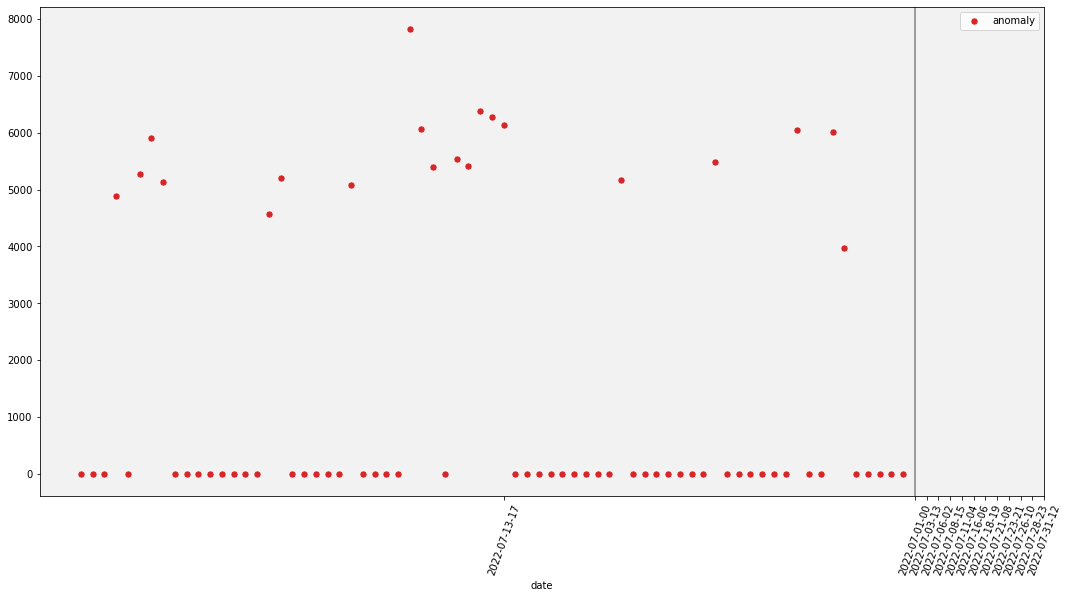

In [215]:
clusters=_statistics.loc[sender]['cmin_07']
#plot_clusters(anomalies=anomalies2[anomalies2.index.str.contains('2022-07')],clusters=clusters,scaler=scaler,test=test, date_from='2022-07-01-00',date_to='2022-07-31-23',expect=('2022-07-12-10','2022-07-13-15'))
plot_monthly_clusters(anomalies=anomalies2[anomalies2.index.str.contains('2022-07')],clusters=clusters,scaler=scaler,test=test, date_from='2022-07-01-00',date_to='2022-07-31-23',expect=('2022-07-12-10','2022-07-13-15'))


222


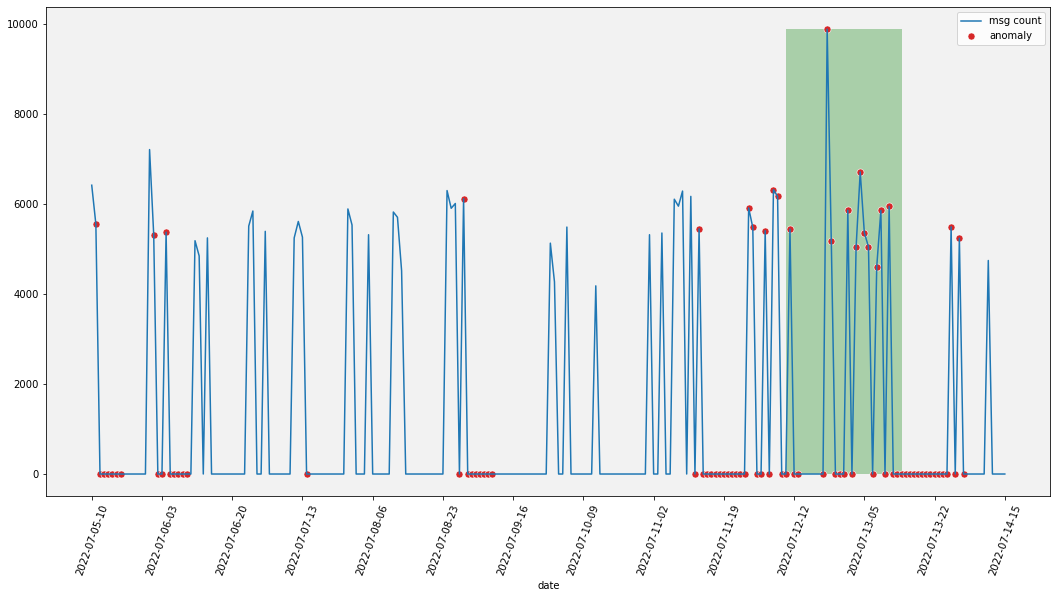

In [601]:
import datetime
import numpy as np
plot_anomalies(anomalies=anomalies2,scaler=scaler,test=test, date_from='2022-07-05-10',date_to='2022-07-14-15',expect=('2022-07-12-10','2022-07-13-15'))

148


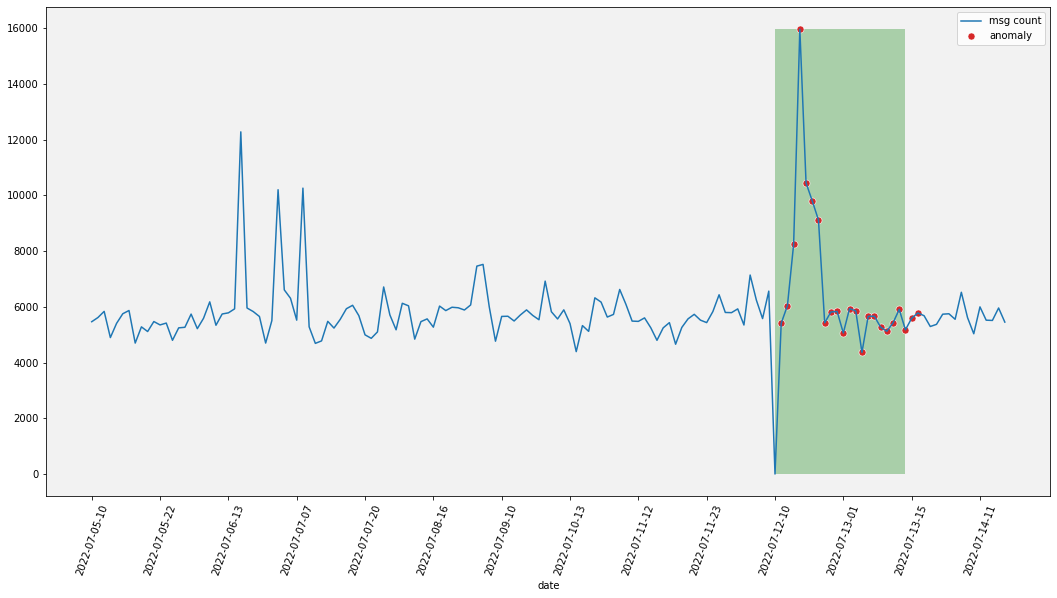

In [538]:
def remove_null_values(anomalies,test):
    anomalies2_not_null = anomalies[scaler.inverse_transform( anomalies[['close']] ) > 0.000001]
    test_not_null = test[(scaler.inverse_transform(test[['close']]) > 0.000001) ].append(test.loc['2022-07-12-10'])
    test_not_null.loc['2022-07-12-10'] = test.loc['2022-07-12-10']
    test_not_null.sort_index(inplace=True)
    return anomalies2_not_null,test_not_null

anomalies2_not_null,test_not_null = remove_null_values(anomalies2,test)
plot_anomalies(anomalies=anomalies2_not_null,scaler=scaler,test=test_not_null, date_from='2022-07-05-10',date_to='2022-07-14-15',expect=('2022-07-12-10','2022-07-13-15'))

In [544]:
_clusters_nn = create_all_clusters(anomalies2_not_null,year=2022)
_clusters = create_all_clusters(anomalies2,year=2022)

In [546]:
_clusters_nn[(2022,10)]

[(Timestamp('2022-10-11 20:00:00'), Timestamp('2022-10-12 00:00:00'), 5),
 (Timestamp('2022-10-12 02:00:00'), Timestamp('2022-10-12 03:00:00'), 2),
 (Timestamp('2022-10-12 05:00:00'), Timestamp('2022-10-12 09:00:00'), 5),
 (Timestamp('2022-10-12 12:00:00'), Timestamp('2022-10-12 17:00:00'), 6),
 (Timestamp('2022-10-12 23:00:00'), Timestamp('2022-10-13 00:00:00'), 2),
 (Timestamp('2022-10-13 06:00:00'), Timestamp('2022-10-13 18:00:00'), 13),
 (Timestamp('2022-10-13 20:00:00'), Timestamp('2022-10-13 21:00:00'), 2),
 (Timestamp('2022-10-13 23:00:00'), Timestamp('2022-10-13 23:00:00'), 1),
 (Timestamp('2022-10-14 01:00:00'), Timestamp('2022-10-14 02:00:00'), 2),
 (Timestamp('2022-10-14 06:00:00'), Timestamp('2022-10-14 11:00:00'), 6),
 (Timestamp('2022-10-14 13:00:00'), Timestamp('2022-10-14 18:00:00'), 6),
 (Timestamp('2022-10-14 21:00:00'), Timestamp('2022-10-15 01:00:00'), 5),
 (Timestamp('2022-10-15 07:00:00'), Timestamp('2022-10-15 10:00:00'), 4),
 (Timestamp('2022-10-15 16:00:00'), T

In [547]:
_clusters[(2022,10)]

[(Timestamp('2022-10-11 20:00:00'), Timestamp('2022-10-15 17:00:00'), 94),
 (Timestamp('2022-10-17 14:00:00'), Timestamp('2022-10-18 07:00:00'), 18),
 (Timestamp('2022-10-19 22:00:00'), Timestamp('2022-10-19 23:00:00'), 2),
 (Timestamp('2022-10-20 02:00:00'), Timestamp('2022-10-20 03:00:00'), 2),
 (Timestamp('2022-10-24 19:00:00'), Timestamp('2022-10-25 07:00:00'), 13),
 (Timestamp('2022-10-26 01:00:00'), Timestamp('2022-10-27 00:00:00'), 24)]

In [540]:
len(anomalies2_not_null), len(anomalies2)

(2193, 3121)

In [535]:
test_not_null.sort_index(inplace=True)

In [536]:
test_not_null

,close,datetime
date,,
2021-01-01-00,-0.006654,2021-01-01 00:00:00
2021-01-01-01,-0.005812,2021-01-01 01:00:00
2021-01-01-04,-0.007392,2021-01-01 04:00:00
2021-01-01-05,-0.007687,2021-01-01 05:00:00
2021-01-01-08,-0.005494,2021-01-01 08:00:00
...,...,...
2023-01-25-13,0.000429,2023-01-25 13:00:00
2023-01-25-14,-0.002354,2023-01-25 14:00:00
2023-01-25-15,-0.000620,2023-01-25 15:00:00


1263


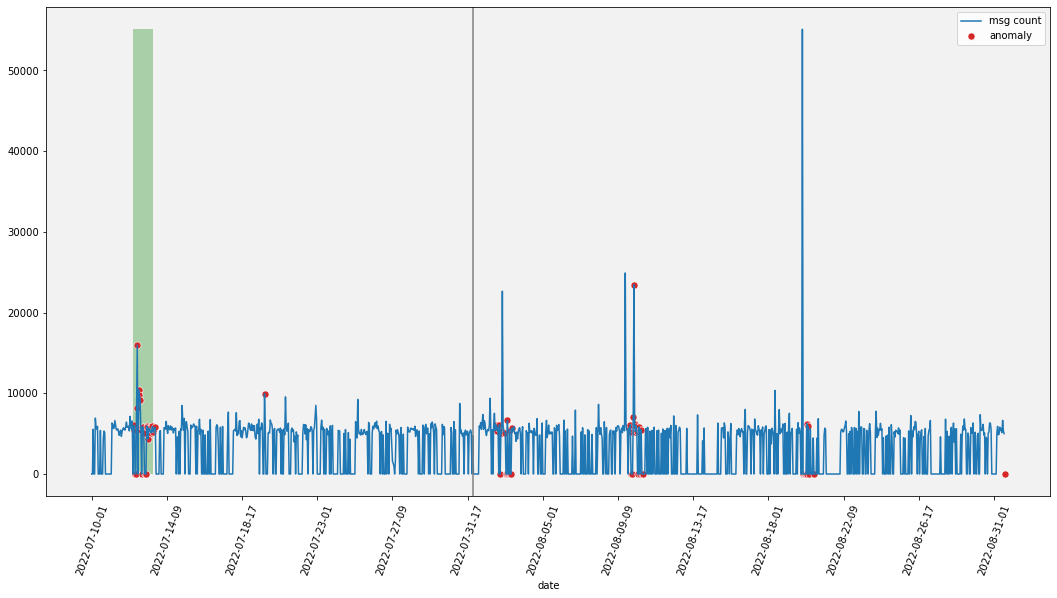

In [210]:
_test = plot_anomalies(anomalies=anomalies2,scaler=scaler,test=test, date_from='2022-07-10-01',date_to='2022-08-31-15',expect=('2022-07-12-10','2022-07-13-15'))

744


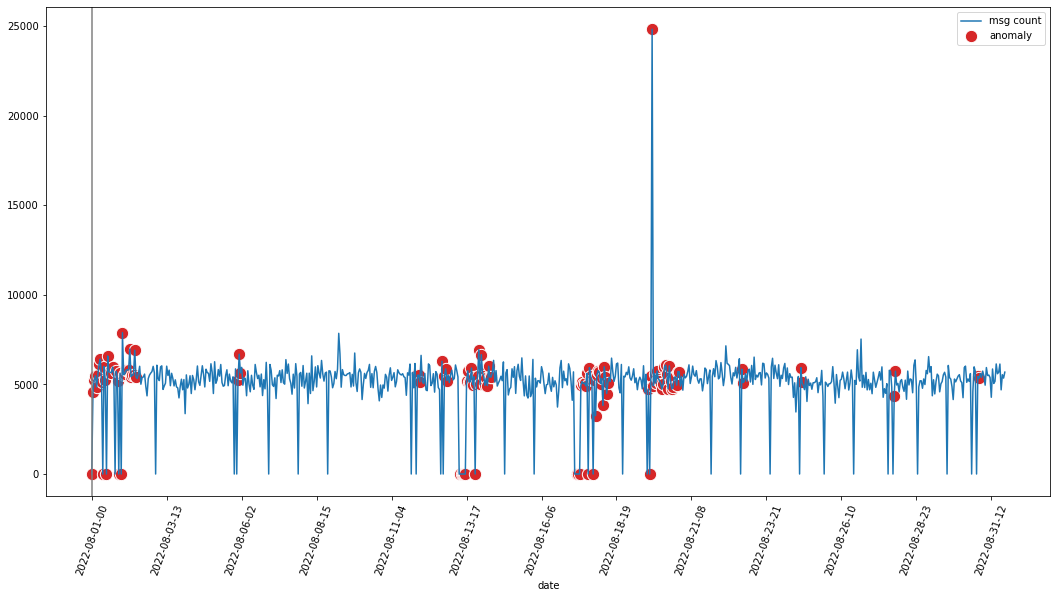

In [713]:
plot_anomalies(anomalies=anomalies2,scaler=scaler,test=test, date_from='2022-08-01-00',date_to='2022-08-31-23')
#plot_anomalies(anomalies=anomalies2,scaler=scaler,test=test, date_from='2022-09-01-00',date_to='2022-09-30-23')

#### error

294


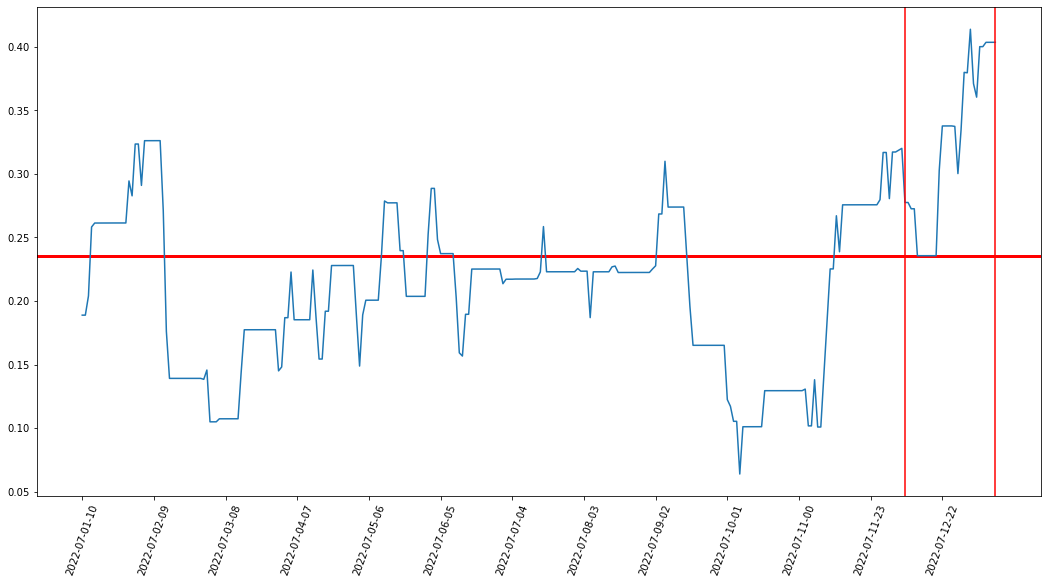

In [602]:
#plot_error(score=score, anomalies=anomalies, date_from='2022-04-06-10',date_to='2022-07-24-15')
plot_error(score=score2, anomalies=anomalies2, date_from='2022-07-01-10',date_to='2022-07-13-15')

In [360]:
def get_next_date(dates, year=2022,month=6,day=None,hour=None):
    _day = day
    if _day is None:
        _day = 1    
    date = datetime.datetime(year,month,_day)
    #dates = dataframe['datetime']
    _dt = min(dates, key=lambda d: abs(d - date))
    return _dt

In [361]:
score.head()
get_next_date(score['datetime'], year=2022,month=1,day=1,hour=None)

Timestamp('2022-07-02 00:00:00')

In [363]:
get_closest_datestring(datestring='2023-01-13-15',dates=score['datetime'])

'2022-09-05-23'

5430


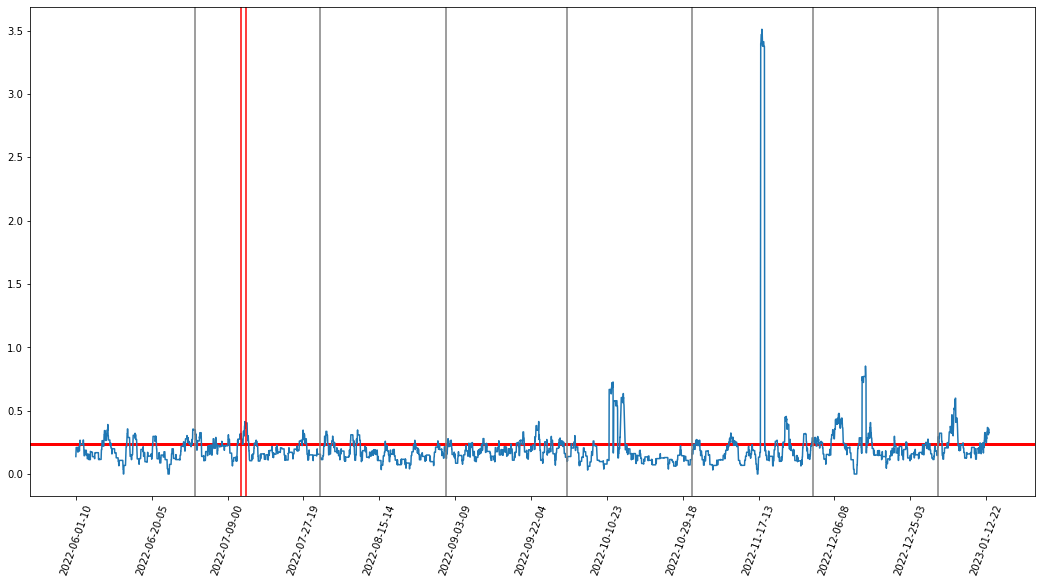

In [603]:
plot_error(score=score2, anomalies=anomalies2, date_from='2022-06-01-10',date_to='2023-01-13-15')

In [325]:
len(anomalies) / len(test)

0.029372496662216287

In [162]:
#_from = get_closest_datestring(datestring='2022-07-12-10', dates = anomalies2['datetime'])
#_to = get_closest_datestring(datestring='2022-07-13-15',dates = anomalies2['datetime'])
#_anomalies = filter_dataframe(anomalies2, date_from=_from, date_to=_to)
#_anomalies

In [247]:
1289 / len(test)

0.07170672007120606

In [224]:
_min,_max, _score.loss[0],len(anomalies) / len(test)

(0.30797412547076913,
 0.4436958193361272,
 0.3166310066487376,
 0.14029817534490432)

In [161]:
len(anomalies)

1296

(array([ 4.,  2.,  2.,  6., 16.]),
 array([0.30797413, 0.33511846, 0.3622628 , 0.38940714, 0.41655148,
        0.44369582]),
 <BarContainer object of 5 artists>)

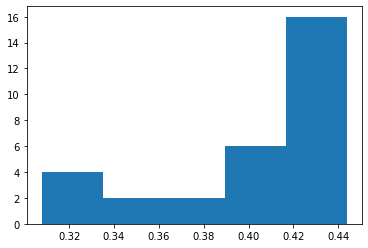

In [210]:
plt.hist(_score.loss[(_score.loss >= _min) & (_score.loss <= _max)], bins=5)

(array([106., 104.,  92., 121.,  81.,  82.,  82.,  75.,  64.,  57.,  46.,
         51.,  48.,  54.,  44.,  32.,  23.,  25.,  45.,  38.,  34.,  25.,
         28.,  26.,  24.,  26.,  25.,  24.,  17.,  25.,  13.,  23.,  32.,
         21.,  19.,  13.,  18.,  29.,  18.,  15.,  16.,  23.,  22.,  15.,
         21.,  19.,  17.,  14.,  11.,  11.]),
 array([0.30797413, 0.31068856, 0.31340299, 0.31611743, 0.31883186,
        0.32154629, 0.32426073, 0.32697516, 0.3296896 , 0.33240403,
        0.33511846, 0.3378329 , 0.34054733, 0.34326177, 0.3459762 ,
        0.34869063, 0.35140507, 0.3541195 , 0.35683394, 0.35954837,
        0.3622628 , 0.36497724, 0.36769167, 0.3704061 , 0.37312054,
        0.37583497, 0.37854941, 0.38126384, 0.38397827, 0.38669271,
        0.38940714, 0.39212158, 0.39483601, 0.39755044, 0.40026488,
        0.40297931, 0.40569375, 0.40840818, 0.41112261, 0.41383705,
        0.41655148, 0.41926591, 0.42198035, 0.42469478, 0.42740922,
        0.43012365, 0.43283808, 0.43555252, 0.

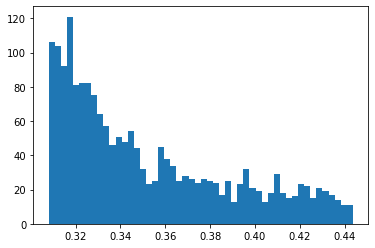

In [208]:
plt.hist(score.loss[(score.loss >= _min) & (score.loss <= _max)], bins=50)

In [188]:
score.loss[score.loss > 6]

date
2021-12-22-10    6.789221
2021-12-22-11    6.789302
2021-12-22-12    6.789172
2021-12-22-13    6.789136
2021-12-22-14    6.789131
                   ...   
2022-01-27-06    6.599164
2022-01-27-07    6.599165
2022-01-27-08    6.599165
2022-01-27-09    6.599167
2022-01-27-10    6.599171
Name: loss, Length: 72, dtype: float64